In [1]:
#numerics and vis
import math
import numpy as np
import pandas as pd
from scipy import stats
import altair as alt
import altair_saver
import sys
import subprocess

import ete3
from ete3 import Tree, TreeStyle, TextFace


root = "/data/tobiassonva/data/eukgen/"
sys.path.insert(0, root)
%cd {root}

from core_functions.microcosm_functions import color_tree, tree_analysis
from core_functions.altair_plots import plot_alignment, plot_cumsum_counts
from core_functions.tree_functions import get_outlier_nodes_by_lognorm

#disable altair max rows
alt.data_transformers.disable_max_rows()
#get default altair style'
%run ~/scripts/altair_style_config_default.py

#dont wrap text output from cells
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

# pandas autodetect column width
pd.set_option('display.max_colwidth', 0)




/vf/users/tobiassonva/data/eukgen


/tmp/ipykernel_971507/1437672245.py:29: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
VALIDATE TQtree2 models

In [ ]:
import io

#read and split data table from IQtree
model_data_file = 'testing/IQtree_models/merged_output.txt'
with open(model_data_file, 'r') as infile:
    #models = [m.split('\n') for m in infile.read().split(';')]
    models = infile.read().split(';')

#loop over models adding observations of rank as index to the data
#data is already sorted
data = pd.DataFrame()
for model in models:
    new_data = pd.read_csv(io.StringIO(model), delim_whitespace=True)
    new_data.reset_index(inplace=True, names='rank')
    new_data['rank'] = [max(10-x, 0) for x in new_data['rank']]
    data = pd.concat([data,new_data])

data_models = pd.Series({model:data[data.Model == model]['rank'].sum()/len(models) for model in data.Model.unique()})
data_models.sort_values(ascending=False)[0:50]

In [ ]:
plot_data = pd.DataFrame(data_models)
plot_data.reset_index(inplace=True)
plot_data.columns = ['model', 'score']
plot_data.sort_values(by='score', ascending=False, inplace=True)
plot_data['name']= [l.split('+')[0] for l in plot_data.model]
plot_data.reset_index(inplace=True, drop=True)
display(plot_data[0:50])

In [ ]:
plot = alt.Chart(plot_data[0:30]).mark_bar().encode(
    x= alt.X('model:O', sort=None, axis=alt.Axis(labelAngle=-45)),
    color = alt.Color('name'),
    y= alt.Y('score'),
).interactive()
plot.width = 1200
plot

In [ ]:
#fix further discrepancies in eukprot species labelling not reachable from orgid

from ete3 import NCBITaxa


error_ids = [2985, 191814, 35133, 88547, 438412, 419944, 1104430, 63605, 35686, 299832, 36769, 91373, 186019, 37163, 446134, 5748, 265536, 3028, 195968, 5774, 2949, 81532, 5709, 947084, 12967]

error_lineages = NCBITaxa().get_lineage_translator(error_ids)

error_lineages

#flat_list = [ x for xs in xss for x in xs ]
error_dict = [x for xs in error_lineages.values() for x in xs]
error_dict = NCBITaxa().get_taxid_translator(error_dict)


errorDF = pd.DataFrame()

for error_id, lineage in error_lineages.items():

    try:
        error_class = [error_dict[c] for c in lineage if NCBITaxa().get_rank([c])[c] == 'class']
    except ValueError:
        error_class = ['none']
        
    if error_class == []:
        error_class = ['none']
        
    error_name = NCBITaxa().get_taxid_translator([error_id])[error_id]
    print(error_id, error_class, error_name)        
    classDF = pd.DataFrame({'species': error_name, 'superkingdom':'Eukaryota', 'class':error_class},index=[error_id])
    errorDF = pd.concat([errorDF, classDF])

errorDF.loc[63605]['class'] = 'Heterolobosea'
errorDF.loc[419944]['class'] = 'Picozoa'
errorDF.loc[438412]['class'] = 'Amoebozoa'


In [ ]:
# plot separate faceted series of KDE estimations for categorical data 
def plot_KDE_per_category(data, 
                          kde_key, 
                          facet_key,
                          orientation='vertical', 
                          facet_width=40, 
                          total_height=500, 
                          title='Data', 
                          plot_range=None,
                          kernel_width = 0.1):

    # encode sample size in the facet labels
    plot_data = data.copy()
    group_sizes = plot_data.groupby(facet_key).size()
    replace_dict = group_sizes.index + ' (n=' + group_sizes.astype(str) + ')'
    plot_data[facet_key] = plot_data[facet_key].replace(replace_dict)
    
    plot_title = title
    
    if plot_range != None:
        kde_range = plot_range
    else:
        kde_range = [plot_data[kde_key].min(), plot_data[kde_key].max()]
        
    # faceted KDE vertical
    if orientation == 'horizontal':
    
        facet_width = facet_width
        facet_height = total_height
        
        # create violin plot
        violins =alt.Chart(plot_data).transform_density(
            kde_key,
            bandwidth = kernel_width,
            as_=[kde_key, 'density'],
            extent=kde_range,
            groupby=[facet_key]

        ).mark_area(orient='horizontal').encode(
            y=alt.Y(kde_key+':Q'),
            color=alt.Color(facet_key+':N', legend=None),
            x=alt.X('density:Q', impute=None, title=None,
                    axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True)),
            tooltip=alt.Tooltip([facet_key])
        )
        
        # create whisker plot
        whiskers =alt.Chart(plot_data).mark_boxplot(size=5, 
                                                    extent=1, 
                                                    outliers=False, 
                                                    ticks={'size':5}).encode(
                y=alt.Y(kde_key+':Q'),
                x=alt.value(facet_width),
                color=alt.value(colorlib['warmgrays'][8])
            )

        # stack and facet with configuration
        layer_chart = alt.layer(violins, whiskers).properties(
                                width=facet_width, 
                                height = facet_height).facet(
                                column=alt.Column(facet_key+':N', title=None, 
                                header=alt.Header(labelAngle=45,
                                                  labelFontSize=12,
                                                  labelPadding = -10,
                                                  labelOrient='bottom'))
        ).configure_facet(spacing=10).configure_view(stroke=None).properties(title = plot_title)

        return layer_chart
    
    # faceted KDE horizontal
    else:
        
        facet_height = facet_width
        facet_width = total_height
        
        # create violin plot
        violins =alt.Chart(plot_data).transform_density(
            kde_key,
            bandwidth = kernel_width,
            as_=[kde_key, 'density'],
            extent=kde_range,
            groupby=[facet_key]

        ).mark_area(orient='vertical').encode(
            x=alt.X(kde_key+':Q'),
            color=alt.Color(facet_key+':N', legend=None),
            y=alt.Y('density:Q', impute=None, title=None,
                    axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True)),
            tooltip=alt.Tooltip([facet_key])
        )

        # create whisker plot
        whiskers =alt.Chart(plot_data).mark_boxplot(size=5, 
                                                    extent=1, 
                                                    outliers=False, 
                                                    ticks={'size':5}).encode(
                x=alt.X(kde_key+':Q'),
                y=alt.value(0),
                color=alt.value(colorlib['warmgrays'][8])
            )

        # stack and facet with configuration
        layer_chart = alt.layer(violins, whiskers).properties(
                                width=facet_width, 
                                height = facet_height).facet(
                                row=alt.Row(facet_key+':N', title=None, 
                                header=alt.Header(labelAngle=0,
                                                  labelFontSize=12,
                                                  labelAlign = 'left'))
        ).configure_facet(spacing=10).configure_view(stroke=None).properties(title = plot_title)

        return layer_chart

---- Temporary ----

In [ ]:
#check wellnes of fit of inverse gamma distribution for tree subset
treefiles = subprocess.run(f"find processing/microcosm2/ -name '*.treefile'",shell=True, text=True, capture_output=True)
treefiles = [f for f in treefiles.stdout.split('\n')][:-1]

In [ ]:
#check wellnes of fit of inverse gamma distribution for tree subset
for file in treefiles:

    #test invgamma
    treefile = file
    print(file)
    tree = Tree(treefile)
    p_high = 0.99
    p_low = 0

    outlier_nodes, dist_series, fitting_params, cutoffs = get_outlier_nodes_by_invgamma(tree, p_low, p_high)
    print(fitting_params)

    x_max = cutoffs[0] + 0.2

    #tree data
    dist_data = pd.DataFrame(dist_series)
    dist_data.columns = ['stem_length']

    #probability density values from fit
    x = np.linspace(stats.invgamma.pdf(0.01, fitting_params[0], fitting_params[1], fitting_params[2]),
                    stats.invgamma.pdf(0.99, fitting_params[0], fitting_params[1], fitting_params[2]), 1000)
    x = np.linspace(0.01, x_max, 1000)

    y = stats.invgamma.pdf(x, fitting_params[0], fitting_params[1], fitting_params[2])

    fit_data = pd.DataFrame({'stem_length':x, 'prob_density':y})
    fit_data = fit_data[fit_data.stem_length < x_max]

    #simulated data
    sim_data = stats.invgamma.rvs(fitting_params[0], fitting_params[1], fitting_params[2], size=len(tree))
    sim_data = pd.DataFrame(pd.Series(sim_data))
    sim_data.columns = ['stem_length']


    #plot cumsum hist
    plot, data = plot_cumsum_counts(dist_data.stem_length, title='experimental')
    plot, fit = plot_cumsum_counts(sim_data.stem_length, title='simulated from fit')

    merged = pd.concat([data, fit])

    cum_plot, merged_data = plot_cumsum_counts(merged, plot_type='default', formatted_data=True,
                                          x_min = 0, x_max=5, x_scale_type='linear', y_scale_type='linear')

    ks_test = stats.ks_2samp(dist_data.stem_length, fit_data.stem_length, alternative='two-sided', mode='auto')
    cum_plot.title = alt.TitleParams(f'p={ks_test.pvalue}, statistic={ks_test.statistic} ', fontSize=12)


    #data_hist with line fit
    title = alt.TitleParams(f"{treefile.split('/')[-1]}, {len(tree)} leaves, 99% CDF {cutoff_high}", fontSize=12)
    data_hist = alt.Chart(dist_data, title = title).mark_bar().encode(
        x= alt.X('stem_length', bin=alt.Bin(extent=[0, x_max], step=0.02)),
        y= alt.Y('count()')

    )


    fit_curve = alt.Chart(fit_data).mark_line(color='red').encode(
        x= alt.X('stem_length', scale=alt.Scale(domain=[0, x_max])),
        y= alt.Y('prob_density')

    )

    plot = alt.layer(data_hist, fit_curve).resolve_scale(y='independent')
    merge_plot = plot | cum_plot
    
    altair_saver.save(merge_plot, treefile+'.html' )

    subprocess.run(f'cp {treefile} /home/tobiassonva/data/eukgen/testing/invgamma_fitting/'.split())
    subprocess.run(f'mv {treefile}.html /home/tobiassonva/data/eukgen/testing/invgamma_fitting/'.split())
    
    print()

In [ ]:
#check wellnes of fit of lognorm distribution for tree subset
from core_functions.tree_functions import get_outlier_nodes_by_lognorm

#test lognorm
#treefile = treefiles[27]
tree = Tree(treefile)
p_high = 0.99
p_low = 0.0

outlier_nodes, dist_series, fitting_params = get_outlier_nodes_by_lognorm(tree, p_low, p_high)
print(fitting_params)

x_max = fitting_params[4] + 0.2

#tree data
dist_data = pd.DataFrame(dist_series)
dist_data.columns = ['stem_length']

#probability density values from fit
x = np.linspace(stats.lognorm.pdf(0.01, fitting_params[0], fitting_params[1], fitting_params[2]),
                stats.lognorm.pdf(0.99, fitting_params[0], fitting_params[1], fitting_params[2]), 1000)
x = np.linspace(0.01, x_max, 1000)

y = stats.lognorm.pdf(x, fitting_params[0], fitting_params[1], fitting_params[2])

fit_data = pd.DataFrame({'stem_length':x, 'prob_density':y})
fit_data = fit_data[fit_data.stem_length < x_max]

#simulated data
sim_data = stats.lognorm.rvs(fitting_params[0], fitting_params[1], fitting_params[2], size=len(tree))
sim_data = pd.DataFrame(pd.Series(sim_data))
sim_data.columns = ['stem_length']


#plot cumsum hist
plot, data = plot_cumsum_counts(dist_data.stem_length, title='experimental')
plot, fit = plot_cumsum_counts(sim_data.stem_length, title='simulated from fit')

merged = pd.concat([data, fit])

cum_plot, merged_data = plot_cumsum_counts(merged, plot_type='default', formatted_data=True,
                                      x_min = 0, x_max=5, x_scale_type='linear', y_scale_type='linear')

ks_test = stats.ks_2samp(dist_data.stem_length, fit_data.stem_length, alternative='two-sided', mode='auto')
cum_plot.title = alt.TitleParams(f'p={ks_test.pvalue}, statistic={ks_test.statistic} ', fontSize=12)


#data_hist with line fits
title = alt.TitleParams(f"{treefile.split('/')[-1]}, {len(tree)} leaves, 99% CDF {fitting_params[4]}", fontSize=12)
data_hist = alt.Chart(dist_data, title = title).mark_bar().encode(
    x= alt.X('stem_length', bin=alt.Bin(extent=[0, x_max], step=0.02)),
    y= alt.Y('count()')

)


fit_curve = alt.Chart(fit_data).mark_line(color='red').encode(
    x= alt.X('stem_length', scale=alt.Scale(domain=[0, x_max])),
    y= alt.Y('prob_density')

)

plot = alt.layer(data_hist, fit_curve).resolve_scale(y='independent')
merge_plot = plot | cum_plot
merge_plot



In [ ]:
CDD_annot = pd.read_csv('processing/euk72_ep3/euk72_ep_hhm.CDD_annotation.tsv', sep='\t', index_col=0)
CDD_annot['score'] = CDD_annot.Prob*CDD_annot.Pairwise_cov
CDD_annot.sort_values(by='score', inplace=True, ascending=False)

In [5]:
# load KEGG search data
# note the swapped labels from HHsuite 
KEGG_annot = pd.read_csv('processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv', sep='\t')
#filter self hits
KEGG_annot = KEGG_annot[KEGG_annot.Query != KEGG_annot.Target]

# rename profiles to merge euk and prok versions of profiles
KEGG_annot['Target'] = [name.split('_')[0] for name in KEGG_annot['Target']]

# transfer annotation from KEGG skipping duplicate entries
KEGG_names = pd.read_csv('/data/tobiassonva/data/databases/kegg/kog_functions.tsv', sep='\t')
KEGG_names.set_index('KOGID', inplace=True)

KEGG_annot['Description'] = KEGG_names[~(KEGG_names.index.duplicated())].loc[KEGG_annot.Target].FUNCTION.values

# sort and index
KEGG_annot.sort_values(by='Score', inplace=True, ascending=False)
KEGG_annot.set_index('Query', inplace=True)

# filter top hits
KEGG_annot_top = KEGG_annot.sort_values(by='Score').reset_index().drop_duplicates(subset='Query', keep='last').set_index('Query')

# KEGG pathway mapping
KEGG_map = pd.read_csv('/data/tobiassonva/data/databases/kegg/kegg_category_mapping.tsv', sep='\t', index_col=0)


# load precomputed KEGG_meta
KEGG_meta = pd.read_csv('/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_merged.tsv', sep='\t', index_col=0)

KEGG_brite = pd.read_csv('/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_brite_map.tsv', dtype=str, sep='\t')
KEGG_brite = KEGG_brite.set_index('brite_id')



In [ ]:
# EUK CLUSTER DATA
euk_cluster = pd.read_csv('processing/euk72_ep/euk72_ep.repseq.cascaded_cluster.tsv', 
                          sep= '\t', names=['cluster_acc', 'acc'], index_col=0)

In [ ]:
# EUK TAX DATA
taxDF = pd.read_csv('/data/tobiassonva/data/eukgen/core_data/taxonomy/euk_prok_merged_protein_revised.tax',
                    sep='\t', names=['acc', 'orgid', 'superkingdom', 'class'], index_col=0)

In [ ]:
# LOCALISATION DATA
loc_annot = pd.read_csv('/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.protatlas_annotation.tsv', sep='\t', index_col=0)

In [ ]:
# merge all tree_data.csv files and clade_data.csv

microcosm_root = 'processing/microcosm/'

treefiles = subprocess.run(f"find {microcosm_root} -maxdepth 2 -name '*.merged.tree_data.tsvedited'", shell=True, text=True, capture_output=True)
treefiles = [file for file in treefiles.stdout.split('\n')][:-1]

print(len(treefiles))
new_data = []

for file in treefiles:
    data = pd.read_csv(file, sep='\t', index_col=0)
    new_data.append(data)

all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data.tsv', sep='\t')

In [ ]:
# merge all tree_data.csv files and clade_data.csv

microcosm_root = '/data/luojaa/eukgen/processing/microcosm_dl/'

treefiles = subprocess.run(f"find {microcosm_root} -maxdepth 2 -name '*.merged.tree_data.tsv'", shell=True, text=True, capture_output=True)
treefiles = [file for file in treefiles.stdout.split('\n')][:-1]

print(len(treefiles))
new_data = []

for file in treefiles:
    data = pd.read_csv(file, sep='\t', index_col=0)
    new_data.append(data)

all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_dl_tree_data.tsv', sep='\t')

In [114]:
tree_data = pd.read_csv('microcosm_tree_data.tsv', sep='\t', index_col=0)
#tree_data.set_index('tree_name', inplace=True)

In [ ]:
# merge all leaf_data for clade mapping
new_data = []
for microcosm in tree_data.index.unique():
    
    leaffile = f'{microcosm_root}/{microcosm}/{microcosm}.merged.fasta.leaf_mapping'
    
    try:
        data = pd.read_csv(leaffile, sep='\t', names = ['acc', 'leaf', 'superkingdom', 'class'])
        data['tree_name'] = [microcosm for _ in data.index]
        new_data.append(data.set_index('tree_name'))
        
    except PermissionError:
        pass
        
all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data.leaf_mapping.tsv', sep='\t')

In [ ]:
leaf_data = pd.read_csv('microcosm_tree_data.leaf_mapping.tsv', sep='\t', index_col=0)

In [ ]:
leaf_data_euk = leaf_data[leaf_data.superkingdom == 'Eukaryota']

In [ ]:
# merge all tree_data.csv files and clade_data.csv

treefiles = subprocess.run(f"find /data/luojaa/eukgen/processing/microcosm_enriched/ -maxdepth 2  -name '*.tree_data.tsv'", shell=True, text=True, capture_output=True)
treefiles = [file for file in treefiles.stdout.split('\n')][:-1]

print(len(treefiles))
new_data = []

for file in treefiles:
    try:
        data = pd.read_csv(file, sep='\t', index_col=0)
        new_data.append(data)
    except PermissionError:
        pass
        
all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data_jac_enriched.tsv', sep='\t')

In [ ]:
# merge all tree_data.csv files and clade_data.csv

treefiles = subprocess.run(f"find /data/luojaa/eukgen/processing/microcosm/ -maxdepth 2 -name '*.tree_data.tsv'", shell=True, text=True, capture_output=True)
treefiles = [file for file in treefiles.stdout.split('\n')][:-1]

print(len(treefiles))
new_data = []

for file in treefiles:
    try:
        data = pd.read_csv(file, sep='\t', index_col=0)
        new_data.append(data)
    except PermissionError:
        pass
        
all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data_jac.tsv', sep='\t')

In [ ]:
tree_data = pd.read_csv('tmp/microcosm_tree_data_jac_enriched.tsv', sep='\t', index_col=0)
tree_data.set_index('tree_name', inplace=True)

In [ ]:
tree_data2 = pd.read_csv('tmp/microcosm_tree_data_jac_enriched2_test2.tsv', sep='\t', index_col=0)
tree_data2.set_index('tree_name', inplace=True)

In [ ]:
# find and merge leafDFs from tree_mapping
# leaves can be present on multiple trees so index is per tree

microcosm_root = '/data/luojaa/eukgen/processing/garbage/microcosm_enriched2.1/'

new_data = []
for microcosm in tree_data2.index.unique():
    
    leaffile = f'{microcosm_root}/{microcosm}/{microcosm}.merged.fasta.leaf_mapping'
    
    
    try:
        data = pd.read_csv(leaffile, sep='\t', names = ['acc', 'leaf', 'superkingdom', 'class'])
        data['tree_name'] = [microcosm for _ in data.index]
        new_data.append(data.set_index('tree_name'))
    except PermissionError:
        pass
        
all_data = pd.concat(new_data, axis=0)
all_data.to_csv('tmp/microcosm_tree_data_jac_enriched.leaf_mapping.tsv', sep='\t')

In [ ]:
# plot overall branch length distribution of most likley sister taxa based on c-ELW

tree_data = tree_data.sort_values(by='c-ELW', ascending=False)

filtered_data = tree_data[(tree_data.stem_length.between(0.00, 2)) &
                          (tree_data['c-ELW'] > 0.8)] #& 
#                           (tree_data.prok_clade_weight >= 0.6)]# & 
                          #~(tree_data.euk_clade_rep.duplicated())]

a = filtered_data[~(filtered_data.stem_length.duplicated())]

#a['dist'] = [np.log(stem) for stem in a['dist']]

#taxa = a.prok_taxa.value_counts().index[0:20].values
taxa = ['Cyanobacteriota', 'Asgard', 'Alphaproteobacteria', 'Actinomycetota']
#taxa = ['Aquificae']

a = a[a.prok_taxa.isin(taxa)]

title = f'Eukaryotic branch length per taxa, Sample_size:{a.shape[0]}'
#title = f'{a.shape[0]}'
#title = f'{len(a)} normalized stem lengths as per Gabaldon 2016'

KDE = alt.Chart(a, title=alt.TitleParams(text=title, fontSize=12)).mark_area(line=True, opacity=0.2).transform_density(
    'stem_length',
    as_=['stem_length', 'density'],
    bandwidth=0.05,
    groupby = ['prok_taxa']
    
    ).encode(
    x=alt.X('stem_length:Q', scale=alt.Scale(domain=[0,2], clamp=True, )),
    y=alt.Y('density:Q', scale=alt.Scale(domain=[0,3], clamp=False)),
    color=alt.Color('prok_taxa'),
    tooltip = alt.Tooltip(['prok_taxa'])

).interactive()

bar = alt.Chart(a, title=title).transform_joinaggregate(
    total='count(*)',
    groupby=['prok_taxa']
    ).transform_calculate(
    pct='1 / datum.total'
    ).mark_bar().encode(
    x=alt.X('stem_length:Q', bin=alt.Bin(step=0.05), scale=alt.Scale(domain=[0,4], clamp=True)),
    y=alt.Y('sum(pct):Q', scale=alt.Scale(domain=[0,0.4])),
    color=alt.Color('prok_taxa'),
    tooltip = alt.Tooltip(['prok_taxa'])

).interactive()
KDE

In [ ]:
#format all taxa specific closest sisters
for taxa in sorted(filtered_data.prok_taxa.unique()):
    print(taxa)
    tree_data_taxa = filtered_data[filtered_data.prok_taxa == taxa]
    
    CDD_hits = CDD_annot_filtered.loc[tree_data_taxa.index]
    
    CDD_good = CDD_hits[CDD_hits['score']>70].sort_values(by='score', ascending=False)
    CDD_good = CDD_good[~(CDD_good.index.duplicated())]
    CDD_good['closest_sister_taxa'] = [taxa]*CDD_good.shape[0]
    
    data[taxa] = CDD_good.round(2)

#write to file
all_data = pd.concat(data.values())

all_data.to_csv('tmp/microcosm_data_CDD.tsv', sep='\t')
    
#write to multi-sheet excel
xlsx_file = 'test2.xlsx'
with pd.ExcelWriter(xlsx_file) as writer:
    for taxa, df in data.items():
        df.to_excel(writer, taxa)

In [ ]:
# plot clade analysis confidence distribution for tests 

from core_functions.altair_plots import plot_cumsum_counts

plot_data = tree_data[tree_data.deltaL != -1]

print(plot_data.index.unique().shape)

tests = ['c-ELW','bp-RELL', 'p-KH', 'p-SH', 'p-AU']
all_data_dict = {}

for test in tests:
    
    plot_data[test] = plot_data[test].astype(float)
    
    print(test)
    plot_data = plot_data.sort_values(by=[test])

    filtered_data = plot_data[(plot_data[test+'_accept'] == '+')]
    best_data = filtered_data.groupby('euk_clade_rep').apply(lambda data: data[test].max())

    
    plot, data1 = plot_cumsum_counts(plot_data[test], title=test+' all')
    plot, data2 = plot_cumsum_counts(filtered_data[test], title=test+' 95% confidence set')
    plot, data3 = plot_cumsum_counts(best_data, title=test+ ' maximum')
    
    
    all_data = pd.concat([data3,data1,data2])
    
    plot, data = plot_cumsum_counts(all_data, formatted_data=True, plot_type='default', 
                                x_scale_type='linear', y_scale_type='linear', 
                               x_min=0, x_max=1, title='Confidence distributions '+test, x_label='probability')
    
    display(plot)
    
    all_data_dict['all_'+test] = data1
    all_data_dict['best_'+test] = data2

In [ ]:
# plot changes in cELW contributions across euk_clade_scopes

all_data = []
for i in range(1,25):

    system_data = tree_data[(tree_data.euk_scope_len > i)
                            & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))]

    tax_data = system_data[['prok_taxa', 'c-ELW']]
    tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum().sort_values(by='c-ELW', ascending=False).round(2))
    tax_data.columns=[i]
    all_data.append((tax_data/tax_data.sum()).round(3))

plot_data = pd.concat(all_data, axis = 1).fillna(0).reset_index()

plot_data

plot_data = plot_data.melt(id_vars='prok_taxa', value_vars=plot_data.columns)

plot_tags = ['Actinomycetota', 'Gammaproteobacteria', 'Asgard', 'Bacillota', 'Alphaproteobacteria', 'FCB group', 'PVC group',
            'Cyanobacteriota', 'Euryarchaeota', 'TACK group']

plot_data = plot_data[(plot_data.variable > -1) & (plot_data.prok_taxa.isin(plot_tags))]


alt.Chart(plot_data, title='Total cELW').mark_line(strokeWidth=2).encode(
    x=alt.X('variable'),
    y=alt.Y('value'),
    color = alt.Color('prok_taxa'),
    tooltip = alt.Tooltip(['prok_taxa'])
).interactive()

In [ ]:
all_maps = KEGG_map[KEGG_map.category_id.str.startswith('map')].category_id.unique()



plot_tags = ['Actinomycetota', 'Gammaproteobacteria', 'Asgard', 'Bacillota', 'Alphaproteobacteria', 'FCB group', 'PVC group',
            'Cyanobacteriota', 'Euryarchaeota', 'TACK group']

plot_tags = ['Actinomycetota',  'Asgard', 'Alphaproteobacteria',
            'Cyanobacteriota', 'Euryarchaeota', 'TACK group']


# sample interesting taxa with reasonable lengths
plot_data = tree_data[(tree_data.stem_length.between(0, 4)) 
                      & (tree_data.prok_taxa.isin(plot_tags))
                          & (tree_data['c-ELW'].between(0.7, 1))
                      & (tree_data.euk_leaf_clade == False)
                      & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (tree_data.euk_scope_len > 5)
                      #& (tree_data.index.isin(mics_with_cogs))
                      #& (tree_data.prok_taxa == 'Asgard')
                      ]

plot_data = plot_data.sort_values(by='c-ELW', ascending=False).drop_duplicates(subset='euk_clade_rep', keep='first')

print(plot_data.shape)
plot_data['manual_taxa'] = ['Other Bacteria' for taxa in plot_data['prok_taxa']]
plot_data.loc[plot_data.prok_taxa.isin(['Asgard','TACK group', 'Euryarchaeota']), 'manual_taxa'] = 'Archaea'
plot_data.loc[plot_data.prok_taxa == 'Alphaproteobacteria', 'manual_taxa'] = 'Alphaproteobacteria'
#plot_data['manual_taxa'] = ['Alphaproteobacteria' if taxa == 'Alphaproteobacteria' and else 'Other Bacteria' ]


In [ ]:
plot_data['map'] = ['other' for _ in plot_data.index]

translation = ['map03010', 'map00970', 'map03013', 'map03015', 'map03008']
information_processing = ['map03020, map03022', 'map03040', 'map03030', 'map03410', 'map03420', 'map03430', 'map03440', 'map03450']
metabolism = ['map00010','map00020','map00030','map00040','map00051']
mitochondrial_metabolism = ['map00190', 'map00680', 'map00910']

for map_n in [information_processing, translation, metabolism, mitochondrial_metabolism]:

    print(map_n)
    # assign information processing
    KOGS = KEGG_map[KEGG_map.category_id.isin(map_n)].index.unique()
    
    print(len(KOGS))
    
    mics_with_cogs = KEGG_annot_top[KEGG_annot_top.Target.isin(KOGS)].index.unique()
    mics_with_cogs = list(set(mics_with_cogs).intersection(plot_data.index))
    
    if len(mics_with_cogs) > 0:
        map_name =  KEGG_map[KEGG_map.category_id.isin(map_n)].category_name[0]
        plot_data.loc[mics_with_cogs, 'map'] = map_name
        print(f'Added {map_name} with {len(mics_with_cogs)}')

In [ ]:
# faceted KDE vertical
plot_title = ''#'Stem length distributions for Eukaryotic clades (KDE_kernel = 0.1)'

# axis key for KDE
kde_key = 'stem_length'

# KDE range
kde_range = [0, 2]

# facet key
facet_key = 'map'
facet_width = 60
total_height = 300
kernel = 0.1


plot1 =  plot_KDE_per_category(plot_data, 
                          kde_key, 
                          facet_key,
                          orientation='vertical', 
                          facet_width=facet_width, 
                          total_height=total_height, 
                          title=plot_title, 
                          plot_range=kde_range,
                        kernel_width=kernel)


plot2 =  plot_KDE_per_category(plot_data, 
                          kde_key, 
                          facet_key,
                          orientation='horizontal', 
                          facet_width=facet_width, 
                          total_height=total_height, 
                          title=plot_title, 
                          plot_range=kde_range,
                              kernel_width=kernel)

display(plot1, plot2)

In [5]:
# harmonize indexes and drop DELETE
shared_i = set(tree_data.index).intersection(KEGG_annot.index)
tree_data = tree_data.loc[list(shared_i)]
tree_data = tree_data[tree_data.prok_taxa != 'DELETE']

KEGG_annot_top = KEGG_annot.sort_values(by='Score').reset_index().drop_duplicates(subset='Query', keep='last').set_index('Query')

In [7]:
KEGG_brite[KEGG_brite.name.str.contains('ceph')]

name brite_A  \
brite_id                                                                     
00311     Penicillin and cephalosporin biosynthesis [PATH:ko00311]  09100    

         brite_B brite_C level  
brite_id                        
00311     09110   00311   C

In [8]:
KEGG_meta[KEGG_meta.brite_C.str.contains('00311')].index

Index(['K00273', 'K12743', 'K04126', 'K04127', 'K12744', 'K12745', 'K12747',
       'K01060', 'K12748', 'K04128', 'K18062', 'K10852', 'K19200', 'K01434',
       'K24041', 'K17836'],
      dtype='object', name='kogid')

In [33]:
#koglist =['K03236','K03113','K03237','K03238','K03242','K15026','K03239','K03754','K03241','K03680','K03240','K15027','K03262','K03263','K03243','K03264','K03254','K03253','K03252','K03251','K03250','K03249','K03248','K03247','K03246','K03245','K15028','K15029','K15030','K03257','K13025','K03258','K03259','K03260','K24086','K03261']
KOGS = KEGG_map[KEGG_map.category_id =='map03010'].index.unique()
#KOGS = KEGG_map[KEGG_map.category_name.str.contains('K')].index.unique()

KOGS = KEGG_names[KEGG_names.FUNCTION.str.contains('regulatory subunit 10', case=False)].index.unique()
#KOGS = ['K04802']

#brite_id = KEGG_brite[KEGG_brite.brite_C == ''].index.values
#KOGS = KEGG_meta[KEGG_meta.brite_C.str.contains('03051')].index.unique()
#KOGS = KEGG_meta[KEGG_meta.TC.str.contains('2.A.29')].index.unique()

#mics_with_cogs = KEGG_annot_top[KEGG_annot_top.Target.isin(KOGS)].index.unique()
mics_with_cogs = KEGG_annot[KEGG_annot.Target.isin(KOGS)].index.unique()

system_data = tree_data[(tree_data.index.isin(mics_with_cogs))
                      & (tree_data['c-ELW'].between(0.5, 1))
                      #& (tree_data.euk_leaf_clade == False)
                      & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (tree_data.euk_scope_len > 5)
                      #& (tree_data.prok_taxa == 'Alphaproteobacteria')
                      #& (tree_data.prok_taxa.isin(['Asgard', 'Euryarchaeota', 'TACK group']))
                      ]

#system_data = tree_data[(tree_data['c-ELW'] > 0.7) & (tree_data.index.isin(mics_with_cogs))]
#system_data = tree_data[(tree_data['c-ELW'].between(0.5, 0.999)) & (tree_data.prok_taxa == 'Gammaproteobacteria') & (tree_data.index.isin(mics_with_cogs))]
#system_data = tree_data[(tree_data['c-ELW'].between(0.7, 0.999)) & (tree_data.prok_taxa == 'Chlamydiia')]

                        
print(KEGG_names[KEGG_names.index.isin(KOGS)])
print(len(KOGS))

print(len(mics_with_cogs))
print(len(system_data.index.unique()))

systems = iter(system_data.sort_values(by='c-ELW', ascending=False).index.unique())

tax_data = system_data[['prok_taxa', 'c-ELW']]
tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum().sort_values(by='c-ELW', ascending=False).round(2))
display((tax_data/tax_data.sum()).round(3))

                                               FUNCTION
KOGID                                                  
K06694  26S proteasome non-ATPase regulatory subunit 10
K17552  protein phosphatase 1 regulatory subunit 10    
2
6496
37


c-ELW
prok_taxa                     
Gammaproteobacteria      0.198
Alphaproteobacteria      0.117
Campylobacterota         0.101
Betaproteobacteria       0.098
Bacillota                0.089
DELETE                   0.085
TACK group               0.062
Cyanobacteriota          0.056
Actinomycetota           0.053
Asgard                   0.042
FCB group                0.040
PVC group                0.038
Thermodesulfobacteriota  0.020

In [130]:
# sample interesting taxa with long stem lengths

tree_data_backup = tree_data.copy()

tree_data = tree_data.sort_values(by='stem_length').drop_duplicates(subset='euk_clade_rep')

sample_i = tree_data[
    (tree_data['c-ELW'].between(0.7, 0.999))
    #& (tree_data.prok_taxa.isin(plot_tags))
    #& (tree_data.euk_leaf_clade == False)
    & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
    & (tree_data.euk_scope_len > 5)
    & (tree_data.stem_length.between(0.8,1.2))
    #& (tree_data.index.isin(mics_with_cogs))
    #& ~(tree_data.prok_taxa.isin(['Asgard', 'Euryarchaeota', 'TACK group']))
    #& (tree_data.prok_taxa =='Actinomycetota')
].index.unique()

print(len(sample_i))
systems = iter(sample_i)

tax_data = tree_data.loc[sample_i][['prok_taxa', 'c-ELW']]
tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum().sort_values(by='c-ELW', ascending=False).round(2))
display((tax_data/tax_data.sum()).round(3))

tree_data = tree_data_backup.copy()

36


c-ELW
prok_taxa                 
Asgard               0.317
Actinomycetota       0.184
Bacillota            0.132
Cyanobacteriota      0.078
Gammaproteobacteria  0.076
PVC group            0.051
Alphaproteobacteria  0.048
FCB group            0.030
Betaproteobacteria   0.029
Euryarchaeota        0.028
Myxococcota          0.028

System EP00042P048459 has Eukaryotic clades ['EP00013P003857']
Tree has 95 leaves


Target       E-value   Prob  Score  Pairwise_cov  \
Query                                                              
EP00042P048459  K06694  1.100000e-42  100.0  307.3  0.800752       
EP00042P048459  K24483  6.600000e-38  100.0  288.8  0.620290       
EP00042P048459  K10335  4.900000e-36  100.0  268.5  0.737410       

                                                            Description  
Query                                                                    
EP00042P048459  26S proteasome non-ATPase regulatory subunit 10          
EP00042P048459  fibronectin type 3 and ankyrin repeat domains protein 1  
EP00042P048459  ankyrin repeat and SOCS box protein 13

euk_clade_rep    euk_LCA  euk_scope_len            prok_taxa  \
tree_name                                                                       
EP00042P048459  EP00013P003857  Eukaryota  7.0            Alphaproteobacteria   
EP00042P048459  EP00013P003857  Eukaryota  7.0            Gammaproteobacteria   
EP00042P048459  EP00013P003857  Eukaryota  7.0            Actinomycetota        
EP00042P048459  EP00013P003857  Eukaryota  7.0            Alphaproteobacteria   
EP00042P048459  EP00013P003857  Eukaryota  7.0            DELETE                
EP00042P048459  EP00013P003857  Eukaryota  7.0            Alphaproteobacteria   
EP00042P048459  EP00013P003857  Eukaryota  7.0            Alphaproteobacteria   

                    dist  stem_length   deltaL    c-ELW c-ELW_accept    p-AU  \
tree_name                                                                      
EP00042P048459  0.538150  0.136350     0.0000   0.62300  +            0.8470   
EP00042P048459  1.672616  0.134201     6.1669   0.14800  +            0.3170   
EP00042P048459  2.339149  0.136350     4.6302   0.07420  +            0.3580   
EP00042P048459  1.639364  0.078297     6.1764   0.06750  +            0.2730   
EP00042P048459  1.662771  0.078297     13.9680  0.06340  +            0.1360   
EP00042P048459  2.152841  0.136350     7.9979   0.02250  -            0.1510   
EP00042P048459  0.599018  0.134201     18.9040  0.00138  -            0.0109   

               p-AU_accept  
tree_name                   
EP00042P048459  +           
EP00042P048459  +           
EP00042P048459  +           
EP00042P048459  +           
EP00042P048459  +           
EP00042P048459  +           
EP00042P048459  -

alt.VConcatChart(...)

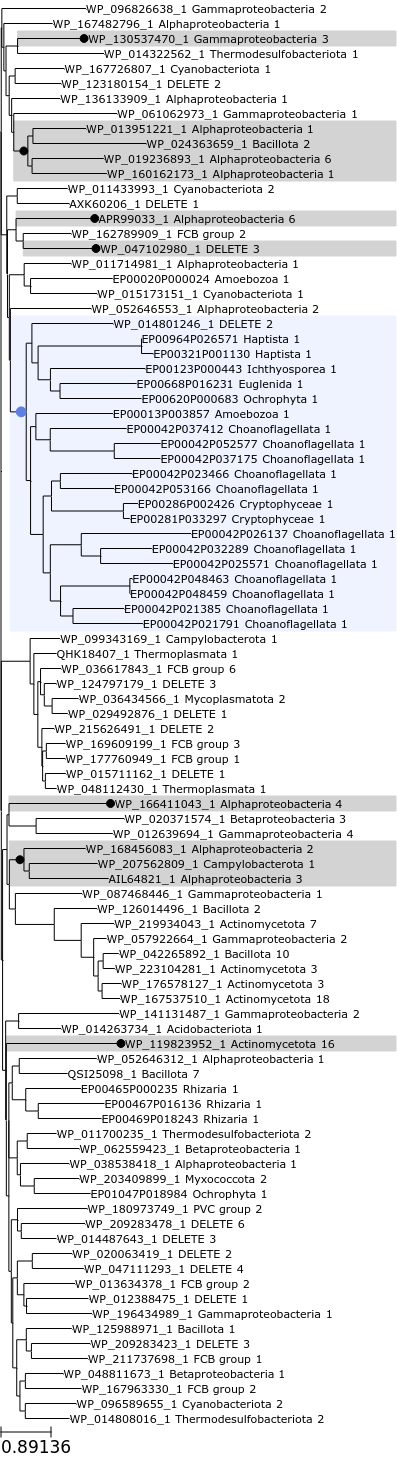

In [52]:
##### microcosm_path = '/data/luojaa/eukgen/processing/microcosm_enriched/'
microcosm_path = '/data/tobiassonva/data/eukgen/processing/microcosm/'
#microcosm_path = '/data/luojaa/eukgen/processing/microcosm_dl/'

#system = 'EP01031P041319'
system = next(systems)

data = tree_data

# print(system)
# try:
#     print(KEGG_names.loc[system])
#     display(KEGG_annot.loc[system, ['Target', 'E-value', 'Prob', 'Score', 'Pairwise_cov', 'Description']])
# except KeyError:
#     print('??')
    
data = data.loc[[system]].sort_values(by='c-ELW', ascending=False)


clades = data.euk_clade_rep.unique()
print(f'System {system} has Eukaryotic clades {clades}')

tree = Tree(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
annot_tree, tree_img = color_tree(tree, view_in_notebook=True)

from core_functions.altair_plots import plot_alignment
aln_file = f'{microcosm_path}{system}/{system}.merged.fasta.muscle'

#leaf_names = [leaf.name for leaf in trees[system].get_leaves()]
leaf_names = [leaf.name for leaf in tree.get_leaves()]

plot, aln_data = plot_alignment(aln_file, seqlimit=100, plot_range=(0,300), label_order=leaf_names)

print(f'Tree has {len(leaf_names)} leaves')
display(KEGG_annot.loc[system, ['Target', 'E-value', 'Prob', 'Score', 'Pairwise_cov', 'Description']])
display(data.iloc[:,[0,4,6,11,12,16,18,25,26,27,28]])
display(plot)

display(tree_img)

In [24]:
plot, aln_data = plot_alignment(aln_file, seqlimit=100, label_order=leaf_names)
aln_data

WP_041695240_1 WP_014242733_1 WP_152128068_1 WP_011316826_1 QRN82705_1  \
0    M              M              M              M              M           
1    R              K              K              K              K           
2    C              I              F              L              V           
3    L              R              I              N              F           
4    M              L              V              I              V           
..  ..             ..             ..             ..             ..           
360  A              P              P              P              P           
361  I              L              I              V              M           
362  R              K              K              E              H           
363  -              -              V              I              I           
364  D              L              Y              A              G           

    WP_011797960_1 EP01088P007165 EP01029P020553 WP_141198041_1  \
0    M              M              M              M               
1    N              K              K              K               
2    I              A              F              I               
3    S              T              V              R               
4    T              I              V              I               
..  ..             ..             ..             ..               
360  P              P              P              P               
361  I              M              M              M               
362  K              R              M              R               
363  R              V              I              -               
364  N              A              A              L               

    WP_053377949_1  ... QJU06298_1 WP_035584512_1 WP_149846676_1 QSW37797_1  \
0    M              ...  M          M              -              M           
1    K              ...  E          K              -              V           
2    V              ...  L          F              -              F           
3    R              ...  S          S              -              R           
4    I              ...  V          I              -              F           
..  ..              ... ..         ..             ..             ..           
360  P              ...  P          P              P              P           
361  I              ...  L          V              V              V           
362  K              ...  K          R              M              L           
363  -              ...  -          I              S              -           
364  I              ...  S          A              R              T           

    WP_041262839_1 WP_014408574_1 EP01037P002471 seqn   entropy   opacity  
0    M              M              M              0    3.898805  0.960273  
1    N              K              K              1    1.401836  0.604950  
2    Y              L              V              2    1.698881  0.690777  
3    I              I              T              3    1.210242  0.540683  
4    V              V              L              4    1.888553  0.737181  
..  ..             ..             ..             ..         ...       ...  
360  N              P              P              360  3.338931  0.931481  
361  Q              V              M              361  1.837637  0.725338  
362  R              K              R              362  1.918957  0.744044  
363  I              -              -              363  0.354961  0.175640  
364  Q              V              V              364  0.857544  0.404295  

[365 rows x 103 columns]

In [10]:
map_id = 'M00152'
elw_cutoff = 0.7

map_kogs = KEGG_map[KEGG_map.category_id.isin(['M00131'])].index

map_kogs = KOGS


print(map_id, KEGG_map[KEGG_map.category_id == map_id].iloc[0, 1])
print(map_kogs)
filter_data = tree_data[tree_data.index.isin(KEGG_annot[KEGG_annot.Target.isin(map_kogs)].index)]
systems = iter(set(filter_data[filter_data['c-ELW'] > elw_cutoff].index))

# best = []
# for tree, data in filter_data[filter_data['c-ELW_accept'].isin(['+', 'NONE'])].sort_values(by='c-ELW', ascending=False).groupby('euk_clade_rep'):
#     best.extend(data['prok_taxa'].values)
    
# all_accepted_sisters = pd.DataFrame([pd.Series(best).value_counts()[0:15],pd.Series(best).value_counts(normalize=True)[0:15]]).transpose()

best = []
for tree, data in filter_data[filter_data['c-ELW_accept'].isin(['+', 'NONE'])].sort_values(by='c-ELW', ascending=False).groupby('euk_clade_rep'):
    best.append(data.iloc[0]['prok_taxa'])
    
all_closest_sisters = pd.DataFrame([pd.Series(best).value_counts()[0:15],pd.Series(best).value_counts(normalize=True)[0:15]]).transpose()

best = []
for tree, data in filter_data[(filter_data['c-ELW_accept'] == '+') &
                            (filter_data['c-ELW'] > elw_cutoff)].sort_values(by='c-ELW', ascending=False).groupby('euk_clade_rep'):
    best.append(data.iloc[0]['prok_taxa'])
    

all_significant_closest_sisters = pd.DataFrame([pd.Series(best).value_counts(),pd.Series(best).value_counts(normalize=True)]).transpose()[0:50]


# display(all_accepted_sisters)
display(all_closest_sisters)
display(all_significant_closest_sisters)

M00152 Cytochrome bc1 complex
['K04802']


count  proportion
Asgard         5.0    0.416667  
TACK group     3.0    0.250000  
Euryarchaeota  2.0    0.166667  
DELETE         2.0    0.166667

Empty DataFrame
Columns: [count, proportion]
Index: []

In [ ]:
KEGG_map_filtered = KEGG_map[KEGG_map.category_id.str.startswith('map')]
tree_data_filtered = tree_data.sort_values(by='c-ELW', ascending=False)
tree_data_filtered = tree_data_filtered[(tree_data_filtered['c-ELW'].between(elw_cutoff, 0.99))]

microcosms_i = KEGG_annot[KEGG_annot.Target.isin(map_kogs)].index.unique()
tax_data = tree_data_filtered[tree_data_filtered.index.isin(microcosms_i)][['prok_taxa', 'c-ELW']]

print(tax_data.index.unique().shape)

tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum())



In [147]:
# microcosm c-ELW per KEGG map

KEGG_map_filtered = KEGG_map[KEGG_map.category_id.str.startswith('map')]
tree_data_filtered = tree_data[
                      #& (tree_data.prok_taxa.isin(plot_tags))
                       (tree_data['c-ELW'].between(0.5, 1))
                      & (tree_data.euk_leaf_clade == False)
                      & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (tree_data.euk_scope_len > 5)
                      #& (tree_data.index.isin(mics_with_cogs))
                      #& (tree_data.prok_taxa == 'Actinomycetota')
                      ]


all_data = []
for map_id, data in KEGG_map_filtered.groupby('category_id'):
    
    #microcosms_i = KEGG_annot[KEGG_annot.Target.isin(data.index)].index.unique()
    microcosms_i = KEGG_annot_top[KEGG_annot_top.Target.isin(data.index)].index.unique()
    
    tax_data = tree_data_filtered[tree_data_filtered.index.isin(microcosms_i)][['prok_taxa', 'c-ELW']]
    
    # normalise
    tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum())
    tax_data = (tax_data / tax_data.sum()).T.round(3)

    # add annotation and KOG counts
    tax_data['map_id'] = map_id
    tax_data['map_name'] = KEGG_map.drop_duplicates(subset='category_id').set_index('category_id').loc[map_id, 'category_name']
    #tax_data['num_kogs'] = KEGG_map[KEGG_map.category_id == map_id].index.shape[0]
    KOGS_in_map = KEGG_map[KEGG_map.category_id == map_id].index
    
    #mics_with_cogs = KEGG_annot[KEGG_annot.Target.isin(KOGS_in_map)].index.unique()
    mics_with_cogs = KEGG_annot_top[KEGG_annot_top.Target.isin(KOGS_in_map)].index.unique()
    
    tax_data['num_mics'] = tree_data_filtered[tree_data_filtered.index.isin(mics_with_cogs)].index.unique().shape[0]
    
    all_data.append(tax_data)
    
    print(map_id, len(microcosms_i), data.iloc[0,1])

map_tax_data_norm = pd.concat(all_data, axis=0, ignore_index=False).fillna(0)
map_tax_data_norm.set_index('map_id', inplace=True)


#map_tax_data_norm.to_csv('tmp/map_tax_cELW_data.tsv', sep='\t')

map00010 1583 Glycolysis / Gluconeogenesis
map00020 703 Citrate cycle (TCA cycle)
map00030 1398 Pentose phosphate pathway
map00040 970 Pentose and glucuronate interconversions
map00051 1259 Fructose and mannose metabolism
map00052 1058 Galactose metabolism
map00053 966 Ascorbate and aldarate metabolism
map00061 612 Fatty acid biosynthesis
map00062 409 Fatty acid elongation
map00071 537 Fatty acid degradation
map00073 115 Cutin, suberine and wax biosynthesis
map00100 556 Steroid biosynthesis
map00120 123 Primary bile acid biosynthesis
map00121 41 Secondary bile acid biosynthesis
map00130 979 Ubiquinone and other terpenoid-quinone biosynthesis
map00140 377 Steroid hormone biosynthesis
map00190 2738 Oxidative phosphorylation
map00195 1037 Photosynthesis
map00196 476 Photosynthesis - antenna proteins
map00220 648 Arginine biosynthesis
map00230 3989 Purine metabolism
map00232 44 Caffeine metabolism
map00240 1980 Pyrimidine metabolism
map00250 819 Alanine, aspartate and glutamate metabolism


map01522 1151 Endocrine resistance
map01523 354 Antifolate resistance
map01524 1063 Platinum drug resistance
map02010 2680 ABC transporters
map02020 4062 Two-component system
map02024 1980 Quorum sensing
map02025 1608 Biofilm formation - Pseudomonas aeruginosa
map02026 873 Biofilm formation - Escherichia coli
map02030 320 Bacterial chemotaxis
map02040 419 Flagellar assembly
map02060 82 Phosphotransferase system (PTS)
map03008 2040 Ribosome biogenesis in eukaryotes
map03010 4184 Ribosome
map03013 3886 Nucleocytoplasmic transport
map03015 1859 mRNA surveillance pathway
map03018 2308 RNA degradation
map03020 800 RNA polymerase
map03022 945 Basal transcription factors
map03030 1729 DNA replication
map03040 2928 Spliceosome
map03050 752 Proteasome
map03060 1183 Protein export
map03070 488 Bacterial secretion system
map03082 1078 ATP-dependent chromatin remodeling
map03083 1447 Polycomb repressive complex
map03230 33 Viral genome structure
map03240 45 Viral replication
map03250 762 Viral lif

map04972 882 Pancreatic secretion
map04973 336 Carbohydrate digestion and absorption
map04974 797 Protein digestion and absorption
map04975 417 Fat digestion and absorption
map04976 701 Bile secretion
map04977 254 Vitamin digestion and absorption
map04978 600 Mineral absorption
map04979 730 Cholesterol metabolism
map05010 5837 Alzheimer disease
map05012 5707 Parkinson disease
map05014 5053 Amyotrophic lateral sclerosis
map05016 4112 Huntington disease
map05017 1760 Spinocerebellar ataxia
map05020 3736 Prion disease
map05022 7100 Pathways of neurodegeneration - multiple diseases
map05030 419 Cocaine addiction
map05031 2097 Amphetamine addiction
map05032 970 Morphine addiction
map05033 398 Nicotine addiction
map05034 2873 Alcoholism
map05100 574 Bacterial invasion of epithelial cells
map05110 674 Vibrio cholerae infection
map05111 840 Biofilm formation - Vibrio cholerae
map05120 701 Epithelial cell signaling in Helicobacter pylori infection
map05130 2058 Pathogenic Escherichia coli infec

In [157]:
map_tax_data_norm.set_index('map_name').T.drop('num_mics').round(2)

map_name                 Glycolysis / Gluconeogenesis  \
prok_taxa                                               
Actinomycetota           0.15                           
Alphaproteobacteria      0.09                           
Asgard                   0.20                           
Bacillota                0.15                           
Betaproteobacteria       0.02                           
Campylobacterota         0.01                           
Chloroflexota            0.01                           
Cyanobacteriota          0.01                           
Deltaproteobacteria      0.01                           
Euryarchaeota            0.02                           
FCB group                0.06                           
Gammaproteobacteria      0.20                           
Mycoplasmatota           0.01                           
Myxococcota              0.01                           
PVC group                0.02                           
Thermodesulfobacteriota  0.03                           
Thermoplasmata           0.01                           
Thermotogae              0.01                           
Acidobacteriota          0.00                           
TACK group               0.00                           
Chlamydiia               0.00                           
Bdellovibrionota         0.00                           
DPANN group              0.00                           

map_name                 Citrate cycle (TCA cycle)  Pentose phosphate pathway  \
prok_taxa                                                                       
Actinomycetota           0.08                       0.21                        
Alphaproteobacteria      0.14                       0.03                        
Asgard                   0.29                       0.14                        
Bacillota                0.11                       0.15                        
Betaproteobacteria       0.03                       0.01                        
Campylobacterota         0.00                       0.02                        
Chloroflexota            0.01                       0.03                        
Cyanobacteriota          0.00                       0.05                        
Deltaproteobacteria      0.01                       0.00                        
Euryarchaeota            0.05                       0.00                        
FCB group                0.05                       0.14                        
Gammaproteobacteria      0.08                       0.08                        
Mycoplasmatota           0.02                       0.02                        
Myxococcota              0.02                       0.03                        
PVC group                0.03                       0.01                        
Thermodesulfobacteriota  0.04                       0.03                        
Thermoplasmata           0.00                       0.00                        
Thermotogae              0.00                       0.02                        
Acidobacteriota          0.02                       0.00                        
TACK group               0.02                       0.02                        
Chlamydiia               0.00                       0.00                        
Bdellovibrionota         0.00                       0.00                        
DPANN group              0.00                       0.00                        

map_name                 Pentose and glucuronate interconversions  \
prok_taxa                                                           
Actinomycetota           0.24                                       
Alphaproteobacteria      0.08                                       
Asgard                   0.13                                       
Bacillota                0.13                                       
Betaproteobacteria       0.01                                       
Campylobacterota         0.00                                    

In [33]:
KEGG_meta

name       EC    TC  \
kogid                                                    
K00844  HK; hexokinase [EC:2.7.1.1]      2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      2.7.1.1  none   
...                             ...          ...   ...   
K07220  K07220; uncharacterized protein  none     none   
K07276  K07276; uncharacterized protein  none     none   
K07338  K07338; uncharacterized protein  none     none   
K07586  ygaC; uncharacterized protein    none     none   
K07742  ylxR; uncharacterized protein    none     none   

                                                            RN    CA       GO  \
kogid                                                                           
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
...                                                        ...   ...      ...   
K07220  none                                                    none  none      
K07276  none                                                    none  none      
K07338  none                                                    none  none      
K07586  none                                                    none  none      
K07742  none                                                    none  none      

       brite_A                            brite_name  
kogid                                                 
K00844  09160   Human Diseases                        
K00844  09130   Environmental Information Processing  
K00844  09150   Organismal Systems                    
K00844  09100   Metabolism                            
K00844  09180   Brite Hierarchies                     
...       ...          ...                            
K07220  09190   Not Included in Pathway or Brite      
K07276  09190   Not Included in Pathway or Brite      
K07338  09190   Not Included in Pathway or Brite      
K07586  09190   Not Included in Pathway or Brite      
K07742  09190   Not Included in Pathway or Brite      

[40572 rows x 8 columns]

In [17]:
# microcosm c-ELW per KEGG brite class

# load precomputed KEGG_meta
KEGG_meta = pd.read_csv('/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_merged.tsv', sep='\t', index_col=0)

KEGG_brite = pd.read_csv('/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_brite_map.tsv', dtype=str, sep='\t')
KEGG_brite = KEGG_brite.set_index('brite_id')

KEGG_meta['brite_A'] = [i.split('|') for i in KEGG_meta['brite_A']]
KEGG_meta['brite_B'] = [i.split('|') for i in KEGG_meta['brite_B']]
KEGG_meta['brite_C'] = [i.split('|') for i in KEGG_meta['brite_C']]

# explode per bright level to analyse

brite_level = 'brite_C'

levels = ['brite_C', 'brite_B', 'brite_A']
levels.remove(brite_level)

KEGG_meta = KEGG_meta.explode(brite_level).drop(levels, axis=1)


KEGG_meta['brite_name'] = [KEGG_brite.loc[i, 'name'] if i in KEGG_brite.index else 'none' for i in KEGG_meta[brite_level]]
KEGG_meta

name brite_C       EC    TC  \
kogid                                                            
K00844  HK; hexokinase [EC:2.7.1.1]      04131   2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      04930   2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      04973   2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      04910   2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      00010   2.7.1.1  none   
...                             ...        ...       ...   ...   
K07220  K07220; uncharacterized protein  99997   none     none   
K07276  K07276; uncharacterized protein  99997   none     none   
K07338  K07338; uncharacterized protein  99997   none     none   
K07586  ygaC; uncharacterized protein    99997   none     none   
K07742  ylxR; uncharacterized protein    99997   none     none   

                                                            RN    CA       GO  \
kogid                                                                           
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
...                                                        ...   ...      ...   
K07220  none                                                    none  none      
K07276  none                                                    none  none      
K07338  none                                                    none  none      
K07586  none                                                    none  none      
K07742  none                                                    none  none      

                                                  brite_name  
kogid                                                         
K00844  Membrane trafficking [BR:ko04131]                     
K00844  Type II diabetes mellitus [PATH:ko04930]              
K00844  Carbohydrate digestion and absorption [PATH:ko04973]  
K00844  Insulin signaling pathway [PATH:ko04910]              
K00844  Glycolysis / Gluconeogenesis [PATH:ko00010]           
...                                          ...              
K07220  Function unknown                                      
K07276  Function unknown                                      
K07338  Function unknown                                      
K07586  Function unknown                                      
K07742  Function unknown                                      

[61302 rows x 8 columns]

In [18]:
KEGG_meta

name brite_C       EC    TC  \
kogid                                                            
K00844  HK; hexokinase [EC:2.7.1.1]      04131   2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      04930   2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      04973   2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      04910   2.7.1.1  none   
K00844  HK; hexokinase [EC:2.7.1.1]      00010   2.7.1.1  none   
...                             ...        ...       ...   ...   
K07220  K07220; uncharacterized protein  99997   none     none   
K07276  K07276; uncharacterized protein  99997   none     none   
K07338  K07338; uncharacterized protein  99997   none     none   
K07586  ygaC; uncharacterized protein    99997   none     none   
K07742  ylxR; uncharacterized protein    99997   none     none   

                                                            RN    CA       GO  \
kogid                                                                           
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
K00844  00299|R00760|R00867|R01326|R01600|R01786|R01961|R03920  none  0004396   
...                                                        ...   ...      ...   
K07220  none                                                    none  none      
K07276  none                                                    none  none      
K07338  none                                                    none  none      
K07586  none                                                    none  none      
K07742  none                                                    none  none      

                                                  brite_name  
kogid                                                         
K00844  Membrane trafficking [BR:ko04131]                     
K00844  Type II diabetes mellitus [PATH:ko04930]              
K00844  Carbohydrate digestion and absorption [PATH:ko04973]  
K00844  Insulin signaling pathway [PATH:ko04910]              
K00844  Glycolysis / Gluconeogenesis [PATH:ko00010]           
...                                          ...              
K07220  Function unknown                                      
K07276  Function unknown                                      
K07338  Function unknown                                      
K07586  Function unknown                                      
K07742  Function unknown                                      

[61302 rows x 8 columns]

In [57]:
KEGG_annot_top = KEGG_annot.sort_values(by='Score').reset_index().drop_duplicates(subset='Query', keep='last').set_index('Query')

tree_data_filtered = tree_data[
                      #& (tree_data.prok_taxa.isin(plot_tags))
                       (tree_data['c-ELW'].between(0.5, 1))
                      & (tree_data.euk_leaf_clade == False)
                      & (tree_data.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (tree_data.euk_scope_len > 5)
                      #& (tree_data.index.isin(mics_with_cogs))
                      #& (tree_data.prok_taxa == 'Actinomycetota')
                      ]

all_data = []
for map_id, data in KEGG_meta.groupby(brite_level):
    
    #microcosms_i = KEGG_annot[KEGG_annot.Target.isin(data.index)].index.unique()
    microcosms_i = KEGG_annot_top[KEGG_annot_top.Target.isin(data.index)].index.unique()
    
    tax_data = tree_data_filtered[tree_data_filtered.index.isin(microcosms_i)][['prok_taxa', 'c-ELW']]
    
    num_mics = len(tax_data.index.unique())
    
    # normalise
    tax_data = pd.DataFrame(tax_data.groupby('prok_taxa').sum())
    tax_data = (tax_data / tax_data.sum()).T.round(3)

    # add annotation and KOG counts
    tax_data['map_id'] = map_id

    tax_data['map_name'] = [KEGG_brite.loc[map_id, 'name'] if map_id in KEGG_brite.index else 'none' for map_id in tax_data['map_id']]
    KOGS_in_map = KEGG_meta[KEGG_meta.brite_name == map_id].index
    
    tax_data['num_mics'] = num_mics
    
    all_data.append(tax_data)
    
    print(map_id, num_mics, data.iloc[0,1])#, tax_data.loc[map_id]['name'])

map_tax_data_norm = pd.concat(all_data, axis=0, ignore_index=False).fillna(0)
map_tax_data_norm.set_index('map_id', inplace=True)

00010 96 00010
00020 59 00020
00030 60 00030
00040 56 00040
00051 66 00051
00052 80 00052
00053 52 00053
00061 41 00061
00062 20 00062
00071 50 00071
00073 5 00073
00100 48 00100
00120 12 00120
00121 4 00121
00130 36 00130
00140 15 00140
00190 95 00190
00194 20 00194
00195 18 00195
00196 2 00196
00199 13 00199
00220 49 00220
00230 185 00230
00232 5 00232
00240 109 00240
00250 72 00250
00253 1 00253
00254 6 00254
00260 122 00260
00261 13 00261
00270 108 00270
00280 69 00280
00290 28 00290
00300 34 00300
00310 42 00310
00311 17 00311
00330 89 00330
00331 0 00331
00332 8 00332
00333 7 00333
00340 42 00340
00350 45 00350
00360 59 00360
00361 18 00361
00362 35 00362
00363 0 00363
00364 8 00364
00365 0 00365
00380 63 00380
00400 35 00400
00401 6 00401
00402 0 00402
00403 0 00403
00404 0 00404
00405 3 00405
00410 42 00410
00430 32 00430
00440 15 00440
00450 45 00450
00460 33 00460
00470 29 00470
00480 78 00480
00500 102 00500
00510 47 00510
00511 58 00511
00512 7 00512
00513 48 00513
00514 16

In [70]:
map_tax_data_norm.to_csv(f'./tmp/map_tax_cELW_data_{brite_level}.tsv', sep='\t')

In [ ]:
map_tax_data_no

In [58]:
map_tax_data_norm.sort_values(by='Actinomycetota', ascending=False)[['map_name', 'num_mics']][0:50]

prok_taxa                                                                 map_name  \
map_id                                                                               
00621      Dioxin degradation [PATH:ko00621]                                         
00572      Arabinogalactan biosynthesis - Mycobacterium [PATH:ko00572]               
00622      Xylene degradation [PATH:ko00622]                                         
00253      Tetracycline biosynthesis [PATH:ko00253]                                  
04658      Th1 and Th2 cell differentiation [PATH:ko04658]                           
04512      ECM-receptor interaction [PATH:ko04512]                                   
04659      Th17 cell differentiation [PATH:ko04659]                                  
00965      Betalain biosynthesis [PATH:ko00965]                                      
01055      Biosynthesis of vancomycin group antibiotics [PATH:ko01055]               
00333      Prodigiosin biosynthesis [PATH:ko00333]                                   
00140      Steroid hormone biosynthesis [PATH:ko00140]                               
04360      Axon guidance [PATH:ko04360]                                              
05150      Staphylococcus aureus infection [PATH:ko05150]                            
00525      Acarbose and validamycin biosynthesis [PATH:ko00525]                      
05235      PD-L1 expression and PD-1 checkpoint pathway in cancer [PATH:ko05235]     
00523      Polyketide sugar unit biosynthesis [PATH:ko00523]                         
00364      Fluorobenzoate degradation [PATH:ko00364]                                 
00361      Chlorocyclohexane and chlorobenzene degradation [PATH:ko00361]            
00061      Fatty acid biosynthesis [PATH:ko00061]                                    
05133      Pertussis [PATH:ko05133]                                                  
00199      Cytochrome P450 [BR:ko00199]                                              
00623      Toluene degradation [PATH:ko00623]                                        
04515      Cell adhesion molecules [BR:ko04515]                                      
04924      Renin secretion [PATH:ko04924]                                            
04927      Cortisol synthesis and secretion [PATH:ko04927]                           
99987      Cofactor metabolism                                                       
04625      C-type lectin receptor signaling pathway [PATH:ko04625]                   
00780      Biotin metabolism [PATH:ko00780]                                          
00062      Fatty acid elongation [PATH:ko00062]                                      
00073      Cutin, suberine and wax biosynthesis [PATH:ko00073]                       
04662      B cell receptor signaling pathway [PATH:ko04662]                          
00627      Aminobenzoate degradation [PATH:ko00627]                                  
01057      Biosynthesis of type II polyketide products [PATH:ko01057]                
05340      Primary immunodeficiency [PATH:ko05340]                                   
04976      Bile secretion [PATH:ko04976]                                             
04660      T cell receptor signaling pathway [PATH:ko04660]                          
04370      VEGF signaling pathway [PATH:ko04370]                                     
01504      Antimicrobial resistance genes [BR:ko01504]                               
00997      Biosynthesis of various other secondary metabolites [PATH:ko00997]        
04724      Glutamatergic synapse [PATH:ko04724]                                      
00643      Styrene degradation [PATH:ko00643]                                        
01523      Antifolate resistance [PATH:ko01523]                                      
01006      Prenyltransferases [BR:ko01006]                                           
02060      Phosphotransferase system (PTS) [PATH:ko02060]                            
04080      Neuroactive ligand-receptor inter

MICROCOSM ANALYSIS DEBUGGING
- 

In [136]:
# main analysis function for tree annotation
# assigns taxonomy to leaves, identifies and trims outliers, assigns LCA nodes and performs distance calculations
# outputs a treeDF with tabulated data for each eukaryotic clade and its corresponding prokaryotic sister-clades
def tree_analysis(tree_file, leaf_mapping, tree_name,
                  outlier_CDF_low=0,
                  outlier_CDF_high=0.99,
                  tree_crop_cutoff=0.30,
                  delete_outliers=True,
                  prok_clade_size=3,
                  prok_clade_purity=0.80,
                  euk_clade_size=5,
                  euk_clade_purity=0.8,
                  exclude_nested_LCAs=True,
                  consider_closest_n_prok_LCAs=7):

    import pandas as pd
    from ete3 import Tree
    from core_functions.tree_functions import get_outlier_nodes_by_lognorm, map_leafDF, \
        get_multiple_soft_LCA_by_relative_purity, weighted_midpoint_root

    # load tree
    print(f'Reading Tree from {tree_file}')
    tree = Tree(tree_file)

    # load leaf mapping from tree cropping
    print(f'Loading leaf data from {leaf_mapping}')
    leafDF = pd.read_csv(leaf_mapping, sep='\t', names=['acc', 'leaf', 'superkingdom', 'full_class', 'rank'],
                         index_col=0)

    # merge all euk classification in to 'Eukaryota' save old class
    leafDF['class'] = leafDF.full_class
    leafDF.loc[leafDF[leafDF.superkingdom == 'Eukaryota'].index, 'class'] = 'Eukaryota'

    # reroot at midpoint before outlier calculation
    tree = weighted_midpoint_root(tree)

    # outlier detection
    print(f'Running outlier detection')
    outlier_nodes, dist_series, fit_params, cutoffs = get_outlier_nodes_by_lognorm(tree, outlier_CDF_low,
                                                                                   outlier_CDF_high,
                                                                                   deletion_cutoff=tree_crop_cutoff)

    # update leafDF with deleted nodes
    outlier_leaves = [leaf.name for node in outlier_nodes for leaf in node.get_leaves()]
    leafDF.loc[outlier_leaves, 'leaf'] = 'DELETED'

    # detach all outlier clades
    if delete_outliers:
        for node in outlier_nodes:
            node.detach()

    # repair tree and collapse unifurcations
    # accoring to the API this shouldn't be neccesary but the detach() funtionality appears inconsistent
    for node in tree.traverse():
        if len(node.children) == 1 or (node.is_leaf() and node.name == ''):
            node.delete()

    # annotate tree with taxonomic info accounting for collapsed branches
    tree = map_leafDF(tree, leafDF)

    # find the best bacterial soft LCA for all taxa
    taxa_list = leafDF[(leafDF.superkingdom.isin(['Bacteria', 'Archaea'])) & (leafDF.leaf != 'DELETED')][
        'class'].unique()

    lca_dict = {}
    for taxa in sorted(taxa_list):
        lca_dict[taxa] = get_multiple_soft_LCA_by_relative_purity(tree, taxa,
                                                                        n_best=9999,
                                                                        min_size=prok_clade_size,
                                                                        min_purity=prok_clade_purity,
                                                                        max_depth=10)

    # find all euk sof LCAs meeting criteria
    lca_dict['Eukaryota'] = get_multiple_soft_LCA_by_relative_purity(tree, 'Eukaryota',
                                                             n_best=9999,
                                                             min_size=euk_clade_size,
                                                             min_purity=euk_clade_purity,
                                                             max_depth=10)


    # display LCA results
    accepted_taxa = [taxa for taxa, node in lca_dict.items() if node != [] and taxa != 'Eukaryota']
    rejected_taxa = [taxa for taxa, node in lca_dict.items() if node == [] and taxa != 'Eukaryota']

    if accepted_taxa:
        print(f'Found acceptable LCAs with size > {prok_clade_size} and purity {prok_clade_purity} for: ')
        for taxa in accepted_taxa:
            node_data = lca_dict[taxa]
            for node in sorted(node_data, key=lambda x:-x[1]):
                print(f'    {taxa + ":":<25} size: {node[1]}\t weight: {round(node[3], 2)}')
                pass

        print(f'\nNo acceptable LCAs with size > {prok_clade_size} and purity {prok_clade_purity} for:')
        print(*sorted(rejected_taxa), sep='\n')

    else:
        print(f'WARNING! Found no acceptable LCAs for Prokayotes, will exit.')
        pass

    print(f'\nFound {len(lca_dict["Eukaryota"])} LCA nodes for Eukaryota')
    for node_data in lca_dict['Eukaryota']:
        print(f'    {"Eukarya:":<25} size: {node_data[1]}\t weight: {round(node_data[3], 2)}')
        pass
    print()

    # if more than three good euk nodes are identified warn and restruct analysis
    if len(lca_dict['Eukaryota']) > 3:
        print(f'WARNING! High paraphyly in Eukaryota, considering the three largest clades of {len(lca_dict["Eukaryota"])} total!')
        lca_dict['Eukaryota'] = lca_dict['Eukaryota'][:3]

    # revert to original eukaryotic classes on tree
    leafDF.columns = ['leaf', 'superkingdom', 'class', 'rank', 'filter_class']
    tree = map_leafDF(tree, leafDF)

    # calculate distances and format DataFrame
    euk_dist_dict = {}

    # separate euk and prok LCA nodes
    all_LCA_data = [node for taxa, nodes in lca_dict.items() for node in nodes]
    all_LCA_nodes = [node[0] for node in all_LCA_data]
    euk_LCA_nodes = [node for node in all_LCA_data if node[0].lca_taxa == 'Eukaryota']
    prok_LCA_nodes = [node for node in all_LCA_data if node[0].lca_taxa != 'Eukaryota']

    # for all eukaryotic nodes
    for i, euk_node_data in enumerate(euk_LCA_nodes):

        # store node reference and basic information
        euk_node = euk_node_data[0]
        euk_node_size = euk_node_data[1]
        euk_clade_is_leaf = euk_node.is_leaf()
        euk_node_acc = euk_node.get_closest_leaf()[0].name
        
        # get the LCA for the identified EUK node as well as the unique class members
        euk_node_LCA, euk_node_scope, euk_node_scope_len = retrieve_LCA_scope(euk_node.get_leaf_names(), leafDF)

        # for all the best prok nodes per taxa
        for j, prok_node_data in enumerate(prok_LCA_nodes):

            # store node reference and basic information
            prok_node = prok_node_data[0]
            prok_node_acc = prok_node.get_closest_leaf()[0].name
            prok_node_is_clade = prok_node.is_leaf()

            # calculate distance metrics
            # absolute node-to-node distance
            dist = euk_node.get_distance(prok_node)
            top_dist = euk_node.get_distance(prok_node, topology_only=True)

            # gabaldon stem length 2016 calculation
            lca_node_prok_euk = euk_node.get_common_ancestor(prok_node)
            raw_stem_length = lca_node_prok_euk.get_distance(euk_node)

            # cannot normalize if clade is leaf
            if euk_clade_is_leaf:
                stem_length = raw_stem_length
                median_euk_branch_length = -1

            # otherwise normalise as per gabaldon
            else:
                euk_branch_lengths = pd.Series([euk_node.get_distance(leaf) for leaf in euk_node.get_leaves()])
                median_euk_branch_length = euk_branch_lengths.median()
                stem_length = raw_stem_length / median_euk_branch_length

            # save data as temp_index: treename_"clade_number", clade_name, clade_size, prok_clade_name, prok_taxa...
            # final value of False is for later filtering purposes
            euk_dist_dict[str(i) + '_' + str(j)] = [tree_name, euk_node_acc, euk_node_data[1], euk_node_data[3], euk_clade_is_leaf, euk_node_LCA, euk_node_scope, euk_node_scope_len,
                                                    prok_node_acc, prok_node_data[1], prok_node_data[3],
                                                    prok_node_is_clade, prok_node.lca_taxa, dist, top_dist, raw_stem_length, median_euk_branch_length, stem_length,
                                                    euk_node, prok_node, False]

    tree_data = pd.DataFrame.from_dict(euk_dist_dict, orient='index',
                                       columns=['tree_name', 'euk_clade_rep', 'euk_clade_size', 'euk_clade_weight','euk_leaf_clade', 'euk_LCA', 'euk_scope', 'euk_scope_len',
                                                'prok_clade_rep', 'prok_clade_size', 'prok_clade_weight',
                                                'prok_leaf_clade', 'prok_taxa', 'dist', 'top_dist',
                                                'raw_stem_length', 'median_euk_leaf_dist', 'stem_length',
                                                'euk_node_ref', 'prok_node_ref', 'include'])

    # if no euk clades were found return empty dataframe
    if tree_data.shape[0] == 0:
        return tree, tree_data

    # drop temporary index
    tree_data.sort_values(by=['top_dist', 'dist'], ascending=True, inplace=True)
    tree_data.set_index('tree_name', inplace=True)

    # check if LCA is decendants of any LCA other node
    # this CURRENTLY breaks downstream formatting of contraints analysis
    if exclude_nested_LCAs:
        print(f'Filtering to remove nested LCAs, nodes that are children of other nodes')
        nested_nodes = []
        for test_node in all_LCA_nodes:

            if any(node in all_LCA_nodes for node in test_node.get_ancestors()):
                test_node_acc = test_node.get_closest_leaf()[0].name
                #print(f'EXCLUDING LCA node {test_node_acc} for {test_node.lca_taxa}')
                nested_nodes.append(test_node)

        # exclude nested LCAs
        tree_data['decendant'] = [any(node in nested_nodes for node in data) for data in tree_data[['euk_node_ref', 'prok_node_ref']].values]
        tree_data = tree_data[~(tree_data.decendant)]

        print()

    # loop through data including only n closest prok LCAs per euk LCAs
    print(f'Consider only closest clades for downstream analysis, clade limit per Eukaryote clade is {consider_closest_n_prok_LCAs}')

    for euk_clade_rep, data in tree_data.groupby('euk_clade_rep'):
        print(f'Including the following LCA list for Eukaryotic LCA: {euk_clade_rep}')
        data.iloc[0].euk_node_ref.add_feature('LCA', 'Eukaryota')

        # consider first n prok LCAs by slicing sorted list
        for i, prok_data in data.iloc[:consider_closest_n_prok_LCAs].iterrows():
            print(f'   {prok_data.prok_taxa + ":":<30} {prok_data.prok_clade_rep:<25} top_dist: {prok_data.top_dist:<8}')
            prok_data.prok_node_ref.add_feature('LCA', prok_data.prok_taxa)

            # add a reference to keep all prok LCAs, quite inefficient
            tree_data.loc[(tree_data.euk_clade_rep == euk_clade_rep) &
                          (tree_data.prok_clade_rep == prok_data.prok_clade_rep), 'include'] = True

        print()

    #delete superflous LCA data and node references
    tree_data = tree_data[tree_data.include]
    tree_data.drop(['euk_node_ref', 'prok_node_ref', 'include', 'decendant'], axis=1, inplace=True)

    tree.ladderize()

    return tree, tree_data



# get LCA ancestor for post tree partitioned EUK clade
def retrieve_LCA_scope(LCA_leaf_names, leafDF):
    
    # hard coded data from ete3 for faster retrevial
    # modified to more finely sample eukarya, additions of "Diaphoretickes" and "Amphorea", "TSAR", "Excavata" etc.
    # for clades with orphans like "opistokonta" which are superclades of other clades like "metazoa" I duble the last entry to avoid popping from an empty list
    class_lineages = {'Cyanobacteriota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Cyanobacteriota/Melainabacteria group',  'Cyanobacteriota'],
    'Gammaproteobacteria': ['root',  'cellular organisms',  'Bacteria',  'Pseudomonadota',  'Gammaproteobacteria'],
    'Bacillota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Bacillota'],
    'Rhodophyta': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Rhodophyta'],
    'Dinophyceae': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Dinophyceae'],
    'Cryptophyceae': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'Cryptista' 'Cryptophyceae'],
    'Euglenida': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata', 'Discoba',  'Euglenozoa',  'Euglenida'],
    'Chlorophyta': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Viridiplantae',  'Chlorophyta'],
    'Oomycota': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Stramenopiles',  'Oomycota'],
    'Ascomycota': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Fungi',  'Dikarya',  'Ascomycota'],
    'Basidiomycota': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Fungi',  'Dikarya',  'Basidiomycota'],
    'Heterolobosea': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata', 'Discoba',  'Heterolobosea'],
    'Apicomplexa': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Apicomplexa'],
    'Ciliophora': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Ciliophora'],
    'Microsporidia': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Fungi',  'Fungi incertae sedis',  'Microsporidia'],
    'Choanoflagellata': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Choanoflagellata'],
    'Alphaproteobacteria': ['root',  'cellular organisms',  'Bacteria',  'Pseudomonadota',  'Alphaproteobacteria'],
    'Betaproteobacteria': ['root',  'cellular organisms',  'Bacteria',  'Pseudomonadota',  'Betaproteobacteria'],
    'Deltaproteobacteria': ['root',  'cellular organisms',  'Bacteria',  'delta/epsilon subdivisions',  'Deltaproteobacteria'],
    'Euryarchaeota': ['root', 'cellular organisms', 'Archaea', 'Euryarchaeota'],
    'Asgard': ['root', 'cellular organisms', 'Archaea', 'Asgard'],
    'Campylobacterota': ['root',  'cellular organisms',  'Bacteria',  'Campylobacterota'],
    'Opisthokonta': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta', 'Opisthokonta'],
    'Metazoa': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Metazoa'],
    'Streptophyta': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Viridiplantae',  'Streptophyta'],
    'Glaucocystophyceae': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Glaucocystophyceae'],
    'Acidobacteriota': ['root',  'cellular organisms',  'Bacteria',  'Acidobacteriota'],
    'Ancyromonadidae': ['root',  'cellular organisms', 'Eukaryota', 'Amorphea', 'Ancyromonadida', 'Ancyromonadidae'],
    'Fungi incertae sedis': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Fungi',  'Fungi incertae sedis', 'Fungi incertae sedis'],
    'Ichthyosporea': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Ichthyosporea'],
    'Malawimonadidae': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata', 'Malawimonadida',  'Malawimonadidae'],
    'Thermoplasmata': ['root',  'cellular organisms',  'Archaea',  'Candidatus Thermoplasmatota',  'Thermoplasmata'],
    'Thermotogae': ['root',  'cellular organisms',  'Bacteria',  'Thermotogota',  'Thermotogae'],
    'Chloroflexota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Chloroflexota'],
    'Thermodesulfobacteriota': ['root',  'cellular organisms',  'Bacteria',  'Thermodesulfobacteriota'],
    'Actinomycetota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Actinomycetota'],
    'Chlamydiia': ['root',  'cellular organisms',  'Bacteria',  'PVC group',  'Chlamydiota',  'Chlamydiia'],
    'Rhizaria': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'TSar', 'Sar', 'Rhizaria'],
    'Mycoplasmatota': ['root',  'cellular organisms',  'Bacteria',  'Terrabacteria group',  'Mycoplasmatota'],
    'Apusozoa': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Obazoa', 'Apusozoa'],
    'Amoebozoa': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Obazoa', 'Amoebozoa'],
    'Jakobida': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata', 'Discoba',  'Jakobida'],
    'Telonemida': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar',  'Telonemida'],
    'Colpodellida': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Colpodellida'],
    'Tsukubamonadidae': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Excavata',  'Discoba',  'Tsukubamonadida',  'Tsukubamonadidae'],
    'Breviatea': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Obazoa', 'Breviatea'],
    'Colponemidia': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Colponemida',  'Colponemidia'],
    'Aphelidea': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Aphelida',  'Aphelidea'],
    'PVC group': ['root', 'cellular organisms', 'Bacteria', 'PVC group'],
    'FCB group': ['root', 'cellular organisms', 'Bacteria', 'FCB group'],
    'TACK group': ['root', 'cellular organisms', 'Archaea', 'TACK group'],
    'DPANN group': ['root', 'cellular organisms', 'Archaea', 'DPANN group'],
    'Fonticulaceae': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Rotosphaerida',  'Fonticulaceae'],
    'Hemimastigophora': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Hemimastigophora'],
    'Perkinsozoa': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Alveolata',  'Perkinsozoa'],
    'Rhodelphea': ['root', 'cellular organisms', 'Eukaryota', 'Rhodelphea'],
    'Haptista': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'Haptista'],
    'CRuMs': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'CRuMs'],
    'Metamonada': ['root', 'cellular organisms', 'Eukaryota', 'Amorphea', 'Excavata', 'Metamonada'],
    'Eukaryota incertae sedis': ['root',  'cellular organisms',  'Eukaryota',  'Eukaryota incertae sedis'],
    'Bigyra': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Stramenopiles',  'Bigyra'],
    'Filasterea': ['root',  'cellular organisms',  'Eukaryota', 'Amorphea', 'Obazoa', 'Opisthokonta',  'Filasterea'],
    'Ochrophyta': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'TSar', 'Sar',  'Stramenopiles',  'Ochrophyta'],
    'Sar': ['root', 'cellular organisms', 'Eukaryota', 'Diaphoretickes', 'TSar', 'Sar', 'Sar'],
    'Prasinodermophyceae': ['root',  'cellular organisms',  'Eukaryota', 'Diaphoretickes', 'Archaeplastida', 'Viridiplantae',  'Prasinodermophyta',  'Prasinodermophyceae'],
    'Myxococcota': ['root', 'cellular organisms', 'Bacteria', 'Myxococcota'],
    'Nebulidea': ['root',  'cellular organisms',  'Eukaryota',  'Diaphoretickes', 'Provora',  'Nebulidia',  'Nebulidea'],
    'Bdellovibrionota': ['root',  'cellular organisms',  'Bacteria',  'Bdellovibrionota'],
    'DELETE': ['DELETE']}
    
    print(LCA_leaf_names)

    leaf_clades = leafDF[leafDF.index.isin(LCA_leaf_names) & (leafDF['class'] != 'DELETE')]['class'].unique()
    print(leaf_clades)


    
    # if no class names returned something is wrong
    if len(leaf_clades) < 1:
        
        return 'ERROR', 'ERROR', 0
    
    # if the group is monophyletic return early as LCA and scope is itself
    if len(leaf_clades) == 1:
        LCA_clade = leaf_clades[0]
        
        return LCA_clade, LCA_clade, 1

    
    lineages = [class_lineages[clade].copy() for clade in leaf_clades]

    print(lineages)
    
    # pop first element of all lists until set of the elements is not single
    LCA_clade = ''
    while True:
        top_clade = {lin.pop(0) for lin in lineages}
        if len(top_clade) == 1:
             LCA_clade = top_clade.pop()
                
        else:
            break

    print(LCA_clade)
    
    return LCA_clade, '|'.join(leaf_clades), len(leaf_clades)

In [137]:
def run_constraint_analysis(constraint_job_data, evo_model, threads):
    from paths_and_parameters import exe_iqtree

    # construct one constrained tree for each euk_LCA*prok_LCA pair
    for index, row in constraint_job_data.iterrows():
        alignment = row.constraint_msa
        constraint_tree = row.constraint_tree

        print(f'Running IQtree2 constrained tree analysis for {constraint_tree}')
        with open(f'{constraint_tree}.log', 'a') as iqtree_logfile:
            # run 1000 ultrafast bootstraps use given model, add -bnni for UFBoot model violations
            iqtree_command = f'{exe_iqtree} -s {alignment} -m {evo_model} -g {constraint_tree} --prefix {constraint_tree} --threads {threads} -B 1000 --redo'
            
            #subprocess.run(iqtree_command.split(), stdout=iqtree_logfile, stderr=iqtree_logfile)

    # concatenate all resulting treefiles for tree testing per euk_LCA
    test_data_list = []

    for euk_LCA, job_data in constraint_job_data.groupby('euk_clade_rep'):
        alignment = job_data.constraint_msa.values[0]

        # maintain DF order for bash cat as iqtree -z follows input order
        bash_cat_order = ' '.join([treefile + '.treefile' for treefile in job_data.constraint_tree])
        forest_file = f'{alignment}.forestfile'
        subprocess.run(f"cat {bash_cat_order} > {forest_file}", shell=True)

        # run iqtree tree evaluation
        with open(f'{alignment}.log', 'a') as iqtree_logfile:
            print(f'Concatenating {job_data.shape[0]} trees for {euk_LCA} and evaluating')
            iqtree_command = f'{exe_iqtree} -s {alignment} -m {evo_model} -z {forest_file} -n 0 -zb 10000 -au --redo'
            
            #subprocess.run(iqtree_command.split(), stdout=iqtree_logfile, stderr=iqtree_logfile)

        # format output database and append to data_list
        iqtreefile = alignment + '.iqtree'
        test_data = parse_IQtree_z_output(iqtreefile, tree_names=None)
        test_data['euk_clade_rep'] = [euk_LCA] * test_data.shape[0]
        test_data['prok_clade_rep'] = job_data.prok_clade_rep.values
        test_data['prok_taxa'] = [taxa for taxa in job_data['prok_taxa']]
        test_data_list.append(test_data)

    # merge all data lists and return
    all_test_data = pd.concat(test_data_list)
    all_test_data.drop('constraint_tree_id', axis=1, inplace=True)

    return all_test_data


def parse_IQtree_z_output(iqtreefile, tree_names=None):
    # read all lines
    with open(iqtreefile, 'r') as iqfile:
        raw_file = iqfile.read()

    # crop out table
    iqtree_data = raw_file.split('USER TREES\n')[1].split('deltaL  :')[0].split('\n')[6:-2]

    # format backup names if no tree_names
    if tree_names is None:
        tree_names = ['tree_' + str(i) for i in range(len(iqtree_data))]

    # split data lines and format into dict for pandas
    iqtree_dict = {}
    for i, line in enumerate(iqtree_data):
        data_list = line.split()
        iqtree_dict[tree_names[i]] = [i for i in data_list[1:]]

    # format pandasDF
    column_names = ['logL', 'deltaL', 'bp-RELL', 'bp-RELL_accept', 'p-KH', 'p-KH_accept', 'p-SH', 'p-SH_accept',
                    'c-ELW', 'c-ELW_accept', 'p-AU', 'p-AU_accept']
    test_data = pd.DataFrame.from_dict(iqtree_dict, orient='index', columns=column_names)

    # set numerical datatypes for relevant columns
    for col in ['logL', 'deltaL', 'bp-RELL', 'p-KH', 'p-SH', 'c-ELW', 'p-AU']:
        test_data[col] = pd.to_numeric(test_data[col])

    test_data = test_data.reset_index(names='constraint_tree_id')
    return test_data

def format_constraint_analysis(root, basename, tree_data, clade_size=10):

    from core_functions.helper_functions import fasta_to_dict, dict_to_fasta
    import pandas as pd
    from ete3 import Tree

    # initialise filepaths
    treefile = root + basename + '.merged.fasta.muscle.treefile.annot'
    msafile = root + basename + '.merged.fasta.muscle'
    constraint_base = root + '/constraint_analysis/'

    # create analysis output folder
    # subprocess.run(f'mkdir {constraint_base}'.split())

    # find all annotated LCA nodes
    tree = Tree(treefile)
    euk_LCA_nodes = []
    prok_LCA_nodes = []

    for node in tree.traverse():
        if 'LCA' in node.features:
            if node.LCA == 'Eukaryota':
                euk_LCA_nodes.append(node)
            else:
                prok_LCA_nodes.append(node)


    # extract all contrstaint tree pairs from tree_data as not all EUK LCAs are to be compared to all prok LCAs
    constraint_pairs = tree_data[['euk_clade_rep', 'prok_clade_rep']].values.tolist()

    # initialize values for jobDF creation
    constraint_data = {}
    index = 0

    # evaluate all euk_LCA nodes individually against all annotated prok_LCAs
    for euk_node in euk_LCA_nodes:

        # node representative is closest_leaf in clade
        euk_node_acc = euk_node.get_closest_leaf()[0].name
        euk_accs = {node for node in euk_node.get_leaf_names()[:clade_size]}

        # output file for filtered alignment saving
        msafile_out = f'{constraint_base}/{euk_node_acc}_constraint.fasta.muscle'

        for n, prok_node in enumerate(prok_LCA_nodes):
            # node representative is closest_leaf in clade
            prok_node_acc = prok_node.get_closest_leaf()[0].name

            # if current euk prok pair not in tree_data pairs exclude it
            if [euk_node_acc, prok_node_acc] not in constraint_pairs:
                print(f'Constraint "{euk_node_acc}, {prok_node_acc}" is excepted as pair does not exist in tree data')
                continue

            # sister group and outgroups
            prok_sister_accs = {name for name in prok_node.get_leaf_names()}

            # outgroup is all prok LCA sequences which are not in the siste rset or a decendant of the euk LCA
            additional_prok_accs = {name for node in prok_LCA_nodes for name in node.get_leaf_names() if
                                    name not in prok_sister_accs.union(euk_accs)}

            # handle cases of singleton outgroup branches
            # ((a,b,c),(d)) should be ((a,b,c),d)

            if len(additional_prok_accs) < 2:
                constraint = f"(({','.join(euk_accs)},{','.join(prok_sister_accs)}),{','.join(additional_prok_accs)});"

            else:
                constraint = f"(({','.join(euk_accs)},{','.join(prok_sister_accs)}),({','.join(additional_prok_accs)}));"

            constraint_file = f'{constraint_base}/{euk_node_acc}_{prok_node_acc}.constraint'
            with open(constraint_file, 'w') as tree:
                tree.write(constraint)

            # save relevant paths and tax info for downstream processing
            constraint_data[index] = [euk_node_acc]
            constraint_data[index].append(prok_node_acc)
            constraint_data[index].append(prok_node.LCA)
            constraint_data[index].append(constraint_file)
            constraint_data[index].append(msafile_out)
            index += 1

        # generate list of all sequences for MSA filtering
        all_prok_accs = {name for node in prok_LCA_nodes for name in node.get_leaf_names()}
        all_LCA_accs = list(euk_accs.union(all_prok_accs))

        # filter MSA for constraint analysis keeping only leaves in relevant LCAs
        aln = fasta_to_dict(file=msafile)
        filter_aln = {key: aln[key] for key in all_LCA_accs}
        dict_to_fasta(filter_aln, write_file=msafile_out, verbose=False)

    # format jobDF for strting IQtree runs
    column_names = ['euk_clade_rep', 'prok_clade_rep', 'prok_taxa', 'constraint_tree', 'constraint_msa']
    constraint_job_data = pd.DataFrame.from_dict(constraint_data, orient='index', columns=column_names)

    # nota all EUK LCAs are to be compared against all prok LCAs
    # filter contraint trees to match tree_data

    constraint_job_data.to_csv(f'{constraint_base}/constraint_trees.tsv', sep='\t', index=None)

    print(f'Formatted {constraint_job_data.shape[0]} guide trees for {len(euk_LCA_nodes)} eukaryotic LCAs')

    return constraint_job_data.set_index('euk_clade_rep')


In [138]:
system = 'EP00013P017966'

tree_data = f'tmp/{system}/{system}.merged.tree_data.tsv' 
tree_data = pd.read_csv(tree_data, sep='\t', index_col=1)

treefile = f'tmp/{system}/{system}.merged.fasta.muscle.treefile.annot'
tree = Tree(treefile)

merged_fasta = f'tmp/{system}/{system}.merged.fasta'
file_basename = system
file_root = f'tmp/{system}/'

annot_tree2, tree_img = color_tree(tree, view_in_notebook=True)
# display(tree_img)

constraint_job_data = pd.read_csv(f'tmp/{system}/constraint_analysis/constraint_trees.tsv', sep='\t')
constraint_job_data

evo_model = 'Q.pfam+F+R7'

threads = 8




# process final tree, find outliers, find LCAs for all taxa and calculate distances
annot_tree, tree_data = tree_analysis(treefile,
                                          merged_fasta + ".leaf_mapping",
                                          file_basename,
                                          delete_outliers=True)

# write to file before
tree_data.to_csv(file_root + file_basename + '.merged.tree_data.tsv', sep='\t')

# draw final master tree and write to file
#color_tree = microcosm.color_tree(annot_tree)
annot_tree.write(features=['LCA', 'counts', 'dist', 'name', 'support', 'taxa'], outfile=treefile + '.annot',
                 format=1)

# break in cases of poor EUK annotation
if tree_data.shape[0] == 0:
    print(f'No tree data was detected in {file_basename} exiting')
    

# skip constraint analysis if only one prok taxa found
if tree_data.prok_clade_rep.unique().shape[0] == 1:

    print(f'Only one prok LCA was detected, exiting without clade analysis')

    # add fake lines to indicate absolute certainty hit
    test_data_cols = ['logL', 'deltaL', 'bp-RELL', 'bp-RELL_accept', 'p-KH', 'p-KH_accept',
                      'p-SH', 'p-SH_accept', 'c-ELW', 'c-ELW_accept', 'p-AU', 'p-AU_accept']

    empty_test_data = pd.DataFrame('+', index=range(tree_data.shape[0]), columns=test_data_cols)
    empty_test_data[['bp-RELL', 'p-KH', 'p-SH', 'c-ELW', 'p-AU']] = [[1] * 5] * tree_data.shape[0]
    empty_test_data[['logL', 'deltaL']] = [[-1] * 2] * tree_data.shape[0]

    merged_data = pd.concat([tree_data.reset_index(), empty_test_data], axis=1)
    merged_data.to_csv(file_root + file_basename + '.merged.tree_data.tsv', sep='\t')


# format constraint trees for clade likelihood analysis
constraint_job_data = format_constraint_analysis(file_root, file_basename, tree_data)

# dirty grep of model selected by modelfinder
with open(file_root + file_basename + '.merged.fasta.muscle.iqtree', 'r') as iqtreefile:
    best_fit_text = 'Best-fit model according to'
    evo_model = [line.rsplit(':',1)[1].strip() for line in iqtreefile.readlines() if line.startswith(best_fit_text)][0]

# calculate constrained IQtrees and format results, merge into tree_data
all_test_data = run_constraint_analysis(constraint_job_data, evo_model, threads)

test_data_cols = ['logL', 'deltaL', 'bp-RELL', 'bp-RELL_accept', 'p-KH', 'p-KH_accept',
                 'p-SH', 'p-SH_accept', 'c-ELW','c-ELW_accept', 'p-AU', 'p-AU_accept']

#reset indexes and
merged_data = pd.concat([tree_data.sort_values(by=['euk_clade_rep', 'prok_clade_rep']).reset_index(),
                         all_test_data.sort_values(by=['euk_clade_rep', 'prok_clade_rep']).reset_index().loc[:,test_data_cols]], axis=1)
merged_data.to_csv(file_root + file_basename + '.merged.tree_data.tsv', sep='\t')

merged_data.set_index('tree_name', inplace=True)


Reading Tree from tmp/EP00013P017966/EP00013P017966.merged.fasta.muscle.treefile.annot
Loading leaf data from tmp/EP00013P017966/EP00013P017966.merged.fasta.leaf_mapping
Running outlier detection
Identified 0 outlier nodes outside interval -0.036392184427528236 > d > 3.524836505485356
Found acceptable LCAs with size > 3 and purity 0.8 for: 
    Actinomycetota:           size: 3136	 weight: 0.13
    Actinomycetota:           size: 2095	 weight: 0.13
    Actinomycetota:           size: 1926	 weight: 0.14
    Actinomycetota:           size: 1597	 weight: 0.16
    Actinomycetota:           size: 918	 weight: 0.12
    Actinomycetota:           size: 597	 weight: 0.09
    Actinomycetota:           size: 569	 weight: 0.09
    Actinomycetota:           size: 563	 weight: 0.11
    Actinomycetota:           size: 525	 weight: 0.1
    Actinomycetota:           size: 516	 weight: 0.09
    Actinomycetota:           size: 483	 weight: 0.11
    Actinomycetota:           size: 374	 weight: 0.1
    Act

In [109]:
merged_data.groupby('euk_clade_rep').sum()

euk_clade_size  euk_clade_weight  euk_leaf_clade  \
euk_clade_rep                                                      
EP00057P030292  763             2.051075          0                
EP00064P004790  1253            2.274047          0                

                                                                        euk_LCA  \
euk_clade_rep                                                                     
EP00057P030292  EukaryotaEukaryotaEukaryotaEukaryotaEukaryotaEukaryotaEukaryota   
EP00064P004790  EukaryotaEukaryotaEukaryotaEukaryotaEukaryotaEukaryotaEukaryota   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 euk_scope  \
euk_clade_rep                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
EP00057P030292  Chlorophyta|MetazoaChlorophyta|MetazoaChlorophyta|MetazoaChlorophyta|MetazoaChlorophyta|MetazoaChlorophyta|MetazoaChlorophyta|Metazoa                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
EP00064P004790  Metazoa|Apicomplexa|Basidiomycota|Ascomycota|Dinophyceae|Ochrophyta|Streptophyta|Chlorophyta|AmoebozoaMetazoa|Apicomplexa|Basidiomycota|Ascomycota|Dinophyceae|Ochrophyta|Streptophyta|Chlorophyta|AmoebozoaMetazoa|Apicomplexa|Basidiomycota|Ascomycota|Dinophyceae|Ochrophyta|Streptophyta|Chlorophyta|AmoebozoaMetazoa|Apicomplexa|Basidiomycota|Ascomycota|Dinophyceae|Ochrophyta|Streptophyta|Chlorophyta|AmoebozoaMetazoa|Apicomplexa|Basidiomycota|Ascomycota|Dinophyceae|Ochrophyta|Streptophyta|Chlorophyta|AmoebozoaMetazoa|Apicomplexa|Basidiomycota|Ascomycota|Dinophyceae|Ochrophyta|Streptophyta|Chlorophyta|AmoebozoaMetazoa|Apicomplexa|Basidiomycota|Ascomycota|Dinophyceae|Ochrophyta|Streptophyta|Chlorophyta|Amoebozoa   

                euk_scope_len  \
euk_clade_rep                   
EP00057P030292  14              
EP00064P004790  63              

                                                                                                    prok_clade_rep  \
euk_clade_rep                                                                                                        
EP00057P030292  WP_003780461_1WP_014392127_1WP_046561466_1WP_058085183_1WP_167895818_1WP_193597050_1WP_2

In [112]:
merged_data.sort_values(by='euk_clade_rep').iloc[:,[0,7,-18,-4,-11]]

euk_clade_rep  prok_clade_rep            prok_taxa     c-ELW  \
tree_name                                                                       
EP00013P017966  EP00057P030292  WP_003780461_1  Actinomycetota       0.002790   
EP00013P017966  EP00057P030292  WP_014392127_1  Alphaproteobacteria  0.000708   
EP00013P017966  EP00057P030292  WP_046561466_1  Gammaproteobacteria  0.011700   
EP00013P017966  EP00057P030292  WP_058085183_1  Actinomycetota       0.271000   
EP00013P017966  EP00057P030292  WP_167895818_1  Alphaproteobacteria  0.011700   
EP00013P017966  EP00057P030292  WP_193597050_1  Actinomycetota       0.475000   
EP00013P017966  EP00057P030292  WP_217920825_1  Actinomycetota       0.227000   
EP00013P017966  EP00064P004790  WP_003780461_1  Actinomycetota       0.000126   
EP00013P017966  EP00064P004790  WP_014392127_1  Alphaproteobacteria  0.003240   
EP00013P017966  EP00064P004790  WP_046561466_1  Gammaproteobacteria  0.002740   
EP00013P017966  EP00064P004790  WP_058085183_1  Actinomycetota       0.062900   
EP00013P017966  EP00064P004790  WP_167895818_1  Alphaproteobacteria  0.002570   
EP00013P017966  EP00064P004790  WP_193597050_1  Actinomycetota       0.695000   
EP00013P017966  EP00064P004790  WP_217920825_1  Actinomycetota       0.234000   

                 deltaL  
tree_name                
EP00013P017966  26.7920  
EP00013P017966  27.8490  
EP00013P017966  17.2180  
EP00013P017966  1.1201   
EP00013P017966  17.2190  
EP00013P017966  0.0000   
EP00013P017966  1.2008   
EP00013P017966  39.3550  
EP00013P017966  35.1080  
EP00013P017966  29.6480  
EP00013P017966  7.4820   
EP00013P017966  29.8100  
EP00013P017966  0.0000   
EP00013P017966  5.4401

In [116]:
tree_slice.sort_values(by='euk_clade_rep').iloc[:,[0,7,-18,-4,-11]]

euk_clade_rep  prok_clade_rep            prok_taxa     c-ELW  \
tree_name                                                                       
EP00013P017966  EP00057P030292  WP_014392127_1  Alphaproteobacteria  0.000708   
EP00013P017966  EP00057P030292  WP_003780461_1  Actinomycetota       0.011700   
EP00013P017966  EP00057P030292  WP_058085183_1  Actinomycetota       0.271000   
EP00013P017966  EP00057P030292  WP_193597050_1  Actinomycetota       0.011700   
EP00013P017966  EP00057P030292  WP_046561466_1  Gammaproteobacteria  0.227000   
EP00013P017966  EP00057P030292  WP_167895818_1  Alphaproteobacteria  0.003240   
EP00013P017966  EP00057P030292  WP_217920825_1  Actinomycetota       0.002740   
EP00013P017966  EP00064P004790  WP_193597050_1  Actinomycetota       0.002790   
EP00013P017966  EP00064P004790  WP_046561466_1  Gammaproteobacteria  0.475000   
EP00013P017966  EP00064P004790  WP_167895818_1  Alphaproteobacteria  0.000126   
EP00013P017966  EP00064P004790  WP_058085183_1  Actinomycetota       0.062900   
EP00013P017966  EP00064P004790  WP_014392127_1  Alphaproteobacteria  0.002570   
EP00013P017966  EP00064P004790  WP_003780461_1  Actinomycetota       0.695000   
EP00013P017966  EP00064P004790  WP_217920825_1  Actinomycetota       0.234000   

                 deltaL  
tree_name                
EP00013P017966  27.8490  
EP00013P017966  17.2180  
EP00013P017966  1.1201   
EP00013P017966  17.2190  
EP00013P017966  1.2008   
EP00013P017966  35.1080  
EP00013P017966  29.6480  
EP00013P017966  26.7920  
EP00013P017966  0.0000   
EP00013P017966  39.3550  
EP00013P017966  7.4820   
EP00013P017966  29.8100  
EP00013P017966  0.0000   
EP00013P017966  5.4401

In [131]:
tree_slice = pd.read_csv(f'processing/microcosm/{system}/{system}.merged.tree_data.tsv', sep='\t', index_col=0)
tree_slice.set_index('tree_name').sort_values(by=['euk_clade_rep', 'prok_clade_rep']).iloc[:,[0,4,-18,-4,-11]]

euk_clade_rep  prok_clade_rep            prok_taxa     c-ELW  \
tree_name                                                                       
EP00013P017966  EP00057P030292  WP_003780461_1  Actinomycetota       0.002790   
EP00013P017966  EP00057P030292  WP_014392127_1  Alphaproteobacteria  0.000708   
EP00013P017966  EP00057P030292  WP_046561466_1  Gammaproteobacteria  0.011700   
EP00013P017966  EP00057P030292  WP_058085183_1  Actinomycetota       0.271000   
EP00013P017966  EP00057P030292  WP_167895818_1  Alphaproteobacteria  0.011700   
EP00013P017966  EP00057P030292  WP_193597050_1  Actinomycetota       0.475000   
EP00013P017966  EP00057P030292  WP_217920825_1  Actinomycetota       0.227000   
EP00013P017966  EP00064P004790  WP_003780461_1  Actinomycetota       0.000126   
EP00013P017966  EP00064P004790  WP_014392127_1  Alphaproteobacteria  0.003240   
EP00013P017966  EP00064P004790  WP_046561466_1  Gammaproteobacteria  0.002740   
EP00013P017966  EP00064P004790  WP_058085183_1  Actinomycetota       0.062900   
EP00013P017966  EP00064P004790  WP_167895818_1  Alphaproteobacteria  0.002570   
EP00013P017966  EP00064P004790  WP_193597050_1  Actinomycetota       0.695000   
EP00013P017966  EP00064P004790  WP_217920825_1  Actinomycetota       0.234000   

                 deltaL  
tree_name                
EP00013P017966  26.7920  
EP00013P017966  27.8490  
EP00013P017966  17.2180  
EP00013P017966  1.1201   
EP00013P017966  17.2190  
EP00013P017966  0.0000   
EP00013P017966  1.2008   
EP00013P017966  39.3550  
EP00013P017966  35.1080  
EP00013P017966  29.6480  
EP00013P017966  7.4820   
EP00013P017966  29.8100  
EP00013P017966  0.0000   
EP00013P017966  5.4401

In [132]:
tree_slice = pd.read_csv(f'processing/microcosm/{system}/{system}.merged.tree_data.tsvedited', sep='\t', index_col=0)

tree_slice.sort_values(by=['euk_clade_rep', 'prok_clade_rep']).iloc[:,[0,7,-18,-4,-11]]

euk_clade_rep  prok_clade_rep            prok_taxa     c-ELW  \
tree_name                                                                       
EP00013P017966  EP00057P030292  WP_003780461_1  Actinomycetota       0.011700   
EP00013P017966  EP00057P030292  WP_014392127_1  Alphaproteobacteria  0.000708   
EP00013P017966  EP00057P030292  WP_046561466_1  Gammaproteobacteria  0.227000   
EP00013P017966  EP00057P030292  WP_058085183_1  Actinomycetota       0.271000   
EP00013P017966  EP00057P030292  WP_167895818_1  Alphaproteobacteria  0.003240   
EP00013P017966  EP00057P030292  WP_193597050_1  Actinomycetota       0.011700   
EP00013P017966  EP00057P030292  WP_217920825_1  Actinomycetota       0.002740   
EP00013P017966  EP00064P004790  WP_003780461_1  Actinomycetota       0.695000   
EP00013P017966  EP00064P004790  WP_014392127_1  Alphaproteobacteria  0.002570   
EP00013P017966  EP00064P004790  WP_046561466_1  Gammaproteobacteria  0.475000   
EP00013P017966  EP00064P004790  WP_058085183_1  Actinomycetota       0.062900   
EP00013P017966  EP00064P004790  WP_167895818_1  Alphaproteobacteria  0.000126   
EP00013P017966  EP00064P004790  WP_193597050_1  Actinomycetota       0.002790   
EP00013P017966  EP00064P004790  WP_217920825_1  Actinomycetota       0.234000   

                 deltaL  
tree_name                
EP00013P017966  17.2180  
EP00013P017966  27.8490  
EP00013P017966  1.2008   
EP00013P017966  1.1201   
EP00013P017966  35.1080  
EP00013P017966  17.2190  
EP00013P017966  29.6480  
EP00013P017966  0.0000   
EP00013P017966  29.8100  
EP00013P017966  0.0000   
EP00013P017966  7.4820   
EP00013P017966  39.3550  
EP00013P017966  26.7920  
EP00013P017966  5.4401

In [ ]:

#system = 'EP00923P035571'

for i, system in enumerate(tree_data.index.unique()[6200+3300+12100:]):
    treefile = f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile'
    leaffile = f'{microcosm_path}{system}/{system}.merged.fasta.leaf_mapping'
    old_tree_datafile = f'{microcosm_path}{system}/{system}.merged.tree_data.tsv'

    leafDF = pd.read_csv(leaffile, sep='\t', index_col=0, names = ['acc', 'leaf', 'superkingdom','class', 'x'])

    #treefile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.muscle.treefile.annot'
    #leaffile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.leaf_mapping'

    print('>>> READING FILE:', i, treefile)


    tree_name = system

    tree, new_tree_data = tree_analysis(treefile, leaffile, tree_name,
                      outlier_CDF_low=0,
                      outlier_CDF_high=0.99,
                      tree_crop_cutoff=0.30,
                      delete_outliers=True,
                      prok_clade_size=3,
                      prok_clade_purity=0.80,
                      euk_clade_size=5,
                      euk_clade_purity=0.8,
                      exclude_nested_LCAs=True,
                      consider_closest_n_prok_LCAs=7)

    annot_tree2, tree_img = color_tree(tree, view_in_notebook=True)
    #display(tree_img)

    old_tree_data = pd.read_csv(old_tree_datafile, sep='\t')
    write_data = pd.concat([new_tree_data.reset_index(), old_tree_data.reset_index().iloc[:,-12:]], axis=1).set_index('tree_name')
    write_data.to_csv(old_tree_datafile+'edited', sep='\t')

In [ ]:
system = 'EP00913P019507'

treefile = f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile'
leaffile = f'{microcosm_path}{system}/{system}.merged.fasta.leaf_mapping'
old_tree_datafile = f'{microcosm_path}{system}/{system}.merged.tree_data.tsv'

leafDF = pd.read_csv(leaffile, sep='\t', index_col=0, names = ['acc', 'leaf', 'superkingdom','class', 'x'])

#treefile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.muscle.treefile.annot'
#leaffile = '/home/tobiassonva/data/eukgen/testing/EP00070P024552/EP00070P024552.merged.fasta.leaf_mapping'

print('>>> READING FILE:', treefile)


tree_name = system

tree, new_tree_data = tree_analysis(treefile, leaffile, tree_name,
                  outlier_CDF_low=0,
                  outlier_CDF_high=0.99,
                  tree_crop_cutoff=0.30,
                  delete_outliers=True,
                  prok_clade_size=3,
                  prok_clade_purity=0.80,
                  euk_clade_size=5,
                  euk_clade_purity=0.8,
                  exclude_nested_LCAs=True,
                  consider_closest_n_prok_LCAs=7)

annot_tree2, tree_img = color_tree(tree, view_in_notebook=True)
display(tree_img)

old_tree_data = pd.read_csv(old_tree_datafile, sep='\t')
write_data = pd.concat([new_tree_data.reset_index(), old_tree_data.reset_index().iloc[:,-12:]], axis=1).set_index('tree_name')
#write_data.to_csv(old_tree_datafile+'edited', sep='\t')

In [ ]:
!which pip